In [3]:
# ---- Imports ----
import os
import sys 
os.chdir('..')
sys.path.insert(0, os.getcwd())
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # Before CUDA
import json
import math
import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict


from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.signal import correlate
import matplotlib.pyplot as plt
import dcor

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- Project loader ----
import importlib.util
loader_path = r"Data_loader.py"
spec = importlib.util.spec_from_file_location("data_loader", loader_path)
data_loader = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_loader)

# ---- Feature names (canonical order) ----
varnames_path = r"DataBesa_Variables_names.txt"
with open(varnames_path, "r", encoding="utf-8") as f:
    FEATURE_NAMES = [line.strip() for line in f if line.strip()]

print("#FEATURE_NAMES:", len(FEATURE_NAMES))

import plotly.express as px


#FEATURE_NAMES: 321


# 01 — Structural redundancy removal on RAW trials (Noraxon / MyoMotion)

This notebook implements **Level 1** of the pipeline:

- Load **continuous RAW trials** using  `Data_loader.py`
- Detect **structural redundancies** (same signal / same information) using:
  - semantic rules (name patterns)
  - correlation (Pearson/Spearman)
  - cross-correlation (optional, for top pairs)
  - mutual information (MI)
  - VIF (block-wise)
  - hierarchical clustering of variables
- Export a **canonical feature set**:
  - `keep_features.txt` (feature names)
  - `keep_indices.npy` (indices w.r.t. `DataBesa_Variables_names.txt`)
  - `feature_map.json` (feature -> canonical representative)
  - `redundancy_report.csv`

> Notes:
> - Decisions here are **model-agnostic** and should not use train/val/test splits.
> - We operate on a **representative sample** of raw trials to control compute.


## 0) Configuration

Edit these paths to match your dataset root folders.

- `DATA_ROOT` should point to the folder containing `G01`, `G02`, `G03` subfolders.
- `SUBJECTS_DICT` is the mapping your project already uses.


In [2]:
# ---- Config (auto from Data_loader.py) ----
# Your Data_loader.py already defines:
# - base_folders: mapping group code -> absolute base folder
# - list_patient_ids(base_folder): extracts subject folder names like S001
#
# We build SUBJECTS_DICT automatically from those folders.

BASE_FOLDERS = data_loader.base_folders  # {'G01': '.../young adults (...)', 'G02': ..., 'G03': ...}

SUBJECTS_DICT = {g: data_loader.list_patient_ids(folder) for g, folder in BASE_FOLDERS.items()}

print("Subjects per group:")
for g, subs in SUBJECTS_DICT.items():
    print(g, len(subs), "subjects")
    
# Sampling strategy (compute control)
N_SUBJECTS_PER_GROUP = 5         # random subjects per group
N_TRIALS_PER_SUBJECT = 3         # random raw trials per subject

# Analysis settings
DROP_COLS = {"Time", "patient_id", "group", "day", "block", "trial"}
CORR_THRESH_STRONG = 0.95
CORR_THRESH_SUSPECT = 0.90

# Cross-correlation
MAX_XCORR_PAIRS = 50
MAX_LAG = 50  # samples lag for xcorr; adjust based on sampling rate / downsample

# MI settings
MI_N_SAMPLES = 20000  # subsample rows (timepoints) for MI to save compute

# VIF settings (block-wise)
VIF_BLOCK_SIZE = 40
VIF_THRESH = 10.0

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


Subjects per group:
G01 35 subjects
G02 50 subjects
G03 40 subjects


## 1) Helper functions

In [3]:
def load_subject_trials(group_code: str, subject_id: str, verbose: bool=False):
    """Load all available RAW trial CSVs for one subject using Data_loader.py.
    
    Returns:
      df_list: list[pd.DataFrame] (one per trial, already includes metadata columns)
      path_list: list[str]        (paths for each trial)
    """
    base_folder = BASE_FOLDERS[group_code]
    patient_folder = os.path.join(base_folder, subject_id, "trimmed")
    df_list, path_list = data_loader.load_patient_data(
        patient_folder=patient_folder,
        patient_id=subject_id,
        group_code=group_code,
        verbose=verbose
    )
    return df_list, path_list

def sample_subjects(subjects_dict, n_per_group, seed=42):
    rng = np.random.default_rng(seed)
    sampled = {}
    for g, subs in subjects_dict.items():
        subs = list(subs)
        if len(subs) == 0:
            sampled[g] = []
            continue
        k = min(n_per_group, len(subs))
        sampled[g] = list(rng.choice(subs, size=k, replace=False))
    return sampled

def sample_trials_from_list(df_list, n_trials_per_subject: int, seed=42):
    """Sample a subset of trials from df_list."""
    if not df_list:
        return []
    rng = np.random.default_rng(seed)
    k = min(n_trials_per_subject, len(df_list))
    idx = rng.choice(np.arange(len(df_list)), size=k, replace=False)
    return list(idx)

def extract_signal_matrix(df: pd.DataFrame):
    """Keep only columns that are in FEATURE_NAMES and return (T,F) matrix."""
    cols_present = [c for c in FEATURE_NAMES if c in df.columns]
    missing = [c for c in FEATURE_NAMES if c not in df.columns]
    if missing:
        print(f"Warning: {len(missing)} features missing from a RAW df (will be skipped)." )
    X = df[cols_present].to_numpy(dtype=float)
    return X, cols_present

def corr_matrix(X: np.ndarray, method: str = "pearson"):
    df = pd.DataFrame(X)
    return df.corr(method=method).to_numpy()

def top_correlated_pairs(C: np.ndarray, thresh: float):
    F = C.shape[0]
    pairs = []
    for i in range(F):
        for j in range(i+1, F):
            v = C[i,j]
            if np.isfinite(v) and abs(v) >= thresh:
                pairs.append((i,j,float(v)))
    pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    return pairs


## 2) Load a representative RAW sample (trials)

We sample:
- `N_SUBJECTS_PER_GROUP` per group
- `N_TRIALS_PER_SUBJECT` per subject
and stack all timepoints to build a big (T_total, F) matrix.


In [4]:
sampled_subjects = sample_subjects(SUBJECTS_DICT, N_SUBJECTS_PER_GROUP, seed=RANDOM_SEED)
sampled_subjects


{'G01': [np.str_('S030'),
  np.str_('S017'),
  np.str_('S026'),
  np.str_('S003'),
  np.str_('S018')],
 'G02': [np.str_('S183'),
  np.str_('S045'),
  np.str_('S098'),
  np.str_('S171'),
  np.str_('S150')],
 'G03': [np.str_('S128'),
  np.str_('S140'),
  np.str_('S123'),
  np.str_('S119'),
  np.str_('S104')]}

In [5]:
X_list = []
trial_meta = []  # one entry per sampled trial
cols_present_ref = None

for g, subs in sampled_subjects.items():
    for s in subs:
        df_list, path_list = load_subject_trials(g, s, verbose=False)
        if not df_list:
            continue
        
        idx_trials = sample_trials_from_list(df_list, N_TRIALS_PER_SUBJECT, seed=RANDOM_SEED)
        for idx in idx_trials:
            df_t = df_list[idx].copy()
            if df_t.empty:
                continue
            
            X, cols_present = extract_signal_matrix(df_t)
            if cols_present_ref is None:
                cols_present_ref = cols_present
            else:
                if cols_present != cols_present_ref:
                    common = [c for c in cols_present_ref if c in cols_present]
                    X = df_t[common].to_numpy(dtype=float)
                    cols_present_ref = common
 
            if X.shape[0] < 10:
                continue

            day = str(df_t['day'].iloc[0]) if 'day' in df_t.columns else None
            block = str(df_t['block'].iloc[0]) if 'block' in df_t.columns else None
            trial = str(df_t['trial'].iloc[0]) if 'trial' in df_t.columns else None

            X_list.append(X)
            trial_meta.append({"group": g, "subject": s, "day": day, "block": block, "trial": trial, "T": X.shape[0]})

print("Sampled trials:", len(X_list))
print("Features present:", len(cols_present_ref) if cols_present_ref is not None else 0)


Sampled trials: 45
Features present: 321


In [7]:
# Stack timepoints (may be large; consider downsampling if needed)
X_raw = np.vstack(X_list) if len(X_list) else np.empty((0,0))
feature_names_present = cols_present_ref if cols_present_ref is not None else []
X_raw.shape, len(feature_names_present)
with open("feature_names_present.json", "w") as f:
    json.dump(feature_names_present, f, indent=2)


In [4]:
# Load X_raw
X_raw=np.load("X_raw.npy")
feature_names_present=json.load(open("feature_names_present.json"))

## 3) Correlation-based redundancy candidates

In [ ]:
# Standardize for correlation stability
X_std = StandardScaler().fit_transform(np.nan_to_num(X_raw, nan=0.0, posinf=0.0, neginf=0.0))

C_pearson = corr_matrix(X_std, method="pearson")
C_spearman = corr_matrix(X_std, method="spearman")
pairs_strong = top_correlated_pairs(C_pearson, CORR_THRESH_STRONG)
pairs_suspect = top_correlated_pairs(C_pearson, CORR_THRESH_SUSPECT)

print("Strong pairs |rho|>=", CORR_THRESH_STRONG, ":", len(pairs_strong))
print("Suspect pairs |rho|>=", CORR_THRESH_SUSPECT, ":", len(pairs_suspect))
np.save("corr_pearson.npy", C_pearson)
np.save("corr_spearman.npy", C_spearman)

cand_pairs = pairs_suspect
pairs_with_dcor = []  # list of (i, j, r_pearson, dc)
for (i, j, r) in cand_pairs:
    xi = X_std[:, i]
    xj = X_std[:, j]
    # distance_correlation expects 1D arrays
    dc = float(dcor.distance_correlation(xi, xj))
    pairs_with_dcor.append((i, j, float(r), dc))

    # Save as structured array for reproducibility
arr = np.array(
        pairs_with_dcor,
        dtype=[("i", "i4"), ("j", "i4"), ("r", "f8"), ("dcor", "f8")]
    )
np.save("pairs_pearson_dcor_candidates.npy", arr)
print("Saved:", "pairs_pearson_dcor_candidates.npy")

# -----------------------------
# 5) Print top pairs
# -----------------------------
topk = 20

print("\nTop Pearson strong pairs (top 20):")
for (i, j, r) in pairs_strong[:topk]:
    print(f"{abs(r):.4f}\t{feature_names_present[i]}  <->  {feature_names_present[j]}\t(r={r:.4f})")

if len(pairs_with_dcor) > 0:
    # Top by dCor among candidates
    pairs_sorted_dcor = sorted(pairs_with_dcor, key=lambda t: t[3], reverse=True)

    print("\nTop dCor pairs among Pearson candidates (top 20):")
    for (i, j, r, dc) in pairs_sorted_dcor[:topk]:
        print(f"{dc:.4f}\t|r|={abs(r):.4f}\t{feature_names_present[i]}  <->  {feature_names_present[j]}")

    # Optional: find "nonlinear-ish" pairs (low Pearson but higher dCor) within candidates
    # (This is useful if you also compute candidates by MI/dCor later; with Pearson candidates only, it's limited.)
    print("\nPairs with relatively lower Pearson but higher dCor (example filter):")
    count = 0
    for (i, j, r, dc) in pairs_sorted_dcor:
        if abs(r) < 0.9 and dc > 0.35:
            print(f"dCor={dc:.4f}\t|r|={abs(r):.4f}\t{feature_names_present[i]} <-> {feature_names_present[j]}")
            count += 1
            if count >= 10:
                break

Saved: pairs_pearson_dcor_candidates.npy

Top Pearson strong pairs (top 20):
1.0000	Shoulder Rotation Ext RT (deg)  <->  Noraxon MyoMotion-Joints-Shoulder RT-Rotation Int (deg)	(r=-1.0000)
1.0000	Pelvic Obliquity LT (deg)  <->  Pelvic Obliquity RT (deg)	(r=-1.0000)
1.0000	Pelvic Rotation LT (deg)  <->  Pelvic Rotation RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Lower spine-Tilt Lat LT (deg)  <->  Noraxon MyoMotion-Segments-Lower spine-Tilt Lat RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Lower spine-Rotation LT (deg)  <->  Noraxon MyoMotion-Segments-Lower spine-Rotation RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Upper spine-Tilt Lat LT (deg)  <->  Noraxon MyoMotion-Segments-Upper spine-Tilt Lat RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Upper spine-Rotation LT (deg)  <->  Noraxon MyoMotion-Segments-Upper spine-Rotation RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Head-Tilt Lat LT (deg)  <->  Noraxon MyoMotion-Segments-Head-Tilt Lat

In [9]:
# Show top 20 strong pairs with names
topk = 20
for (i,j,r) in pairs_strong[:topk]:
    print(f"{abs(r):.4f}\t{feature_names_present[i]}  <->  {feature_names_present[j]}\t(r={r:.4f})")


1.0000	Shoulder Rotation Ext RT (deg)  <->  Noraxon MyoMotion-Joints-Shoulder RT-Rotation Int (deg)	(r=-1.0000)
1.0000	Pelvic Obliquity LT (deg)  <->  Pelvic Obliquity RT (deg)	(r=-1.0000)
1.0000	Pelvic Rotation LT (deg)  <->  Pelvic Rotation RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Lower spine-Tilt Lat LT (deg)  <->  Noraxon MyoMotion-Segments-Lower spine-Tilt Lat RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Lower spine-Rotation LT (deg)  <->  Noraxon MyoMotion-Segments-Lower spine-Rotation RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Upper spine-Tilt Lat LT (deg)  <->  Noraxon MyoMotion-Segments-Upper spine-Tilt Lat RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Upper spine-Rotation LT (deg)  <->  Noraxon MyoMotion-Segments-Upper spine-Rotation RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Head-Tilt Lat LT (deg)  <->  Noraxon MyoMotion-Segments-Head-Tilt Lat RT (deg)	(r=-1.0000)
1.0000	Noraxon MyoMotion-Segments-Head-Rotation LT (deg

## 4) Cross-correlation for top pairs (optional)

This helps detect same-signal-but-lagged. We only compute this for a limited number of pairs.


In [10]:
def compute_pairwise_xcorr(X: np.ndarray, pairs, max_lag=50):
    """Compute max normalized cross-correlation within +/- max_lag for given pairs."""
    results = []
    for (i, j, r0) in pairs:
        xi = X[:, i]
        xj = X[:, j]

        # z-score
        xi = (xi - np.mean(xi)) / (np.std(xi) + 1e-12)
        xj = (xj - np.mean(xj)) / (np.std(xj) + 1e-12)

        cc = correlate(xi, xj, mode="full")
        mid = len(cc) // 2
        window = cc[mid - max_lag : mid + max_lag + 1]

        mx = float(np.max(np.abs(window)) / len(xi))   # normalized
        lag = int(np.argmax(np.abs(window)) - max_lag)
        results.append((i, j, r0, mx, lag))
    return results


In [11]:
pairs_for_xcorr = pairs_strong[:MAX_XCORR_PAIRS]
xcorr_results = compute_pairwise_xcorr(X_std, pairs_for_xcorr, max_lag=MAX_LAG)

# Show top 20 by max xcorr
xcorr_results_sorted = sorted(xcorr_results, key=lambda x: x[3], reverse=True)
for (i,j,r0,mx,lag) in xcorr_results_sorted[:20]:
    print(f"xcorr_max={mx:.4f}\tlag={lag:+d}\t{feature_names_present[i]} <-> {feature_names_present[j]}\t(r={r0:.4f})")


xcorr_max=1.0000	lag=+0	Noraxon MyoMotion-Joints-Cervical-Axial LT (deg) <-> Cervical Axial - RT (deg)	(r=-1.0000)
xcorr_max=1.0000	lag=+0	Noraxon MyoMotion-Segments-Upper spine-Tilt Lat LT (deg) <-> Noraxon MyoMotion-Segments-Upper spine-Tilt Lat RT (deg)	(r=-1.0000)
xcorr_max=1.0000	lag=+0	Noraxon MyoMotion-Segments-Head-Tilt Lat LT (deg) <-> Noraxon MyoMotion-Segments-Head-Tilt Lat RT (deg)	(r=-1.0000)
xcorr_max=1.0000	lag=+0	Pelvic Rotation LT (deg) <-> Pelvic Rotation RT (deg)	(r=-1.0000)
xcorr_max=1.0000	lag=+0	Noraxon MyoMotion-Joints-Lumbar-Axial LT (deg) <-> Lumbar Axial - RT (deg)	(r=-1.0000)
xcorr_max=1.0000	lag=+0	Noraxon MyoMotion-Joints-Cervical-Flexion Lat LT (deg) <-> Cervical Lateral - RT (deg)	(r=-1.0000)
xcorr_max=1.0000	lag=+0	Knee Flexion LT (deg) <-> Noraxon MyoMotion-Joints-Knee LT-Extension (deg)	(r=-1.0000)
xcorr_max=1.0000	lag=+0	Knee Flexion RT (deg) <-> Noraxon MyoMotion-Joints-Knee RT-Extension (deg)	(r=-1.0000)
xcorr_max=1.0000	lag=+0	Shoulder Rotation Ext

## 5) Mutual Information (MI) redundancy matrix

MI captures **nonlinear redundancy**. This can be expensive; we subsample timepoints.


In [12]:
def compute_mi_matrix(X: np.ndarray, n_samples=20000, seed=42):
    """
    Compute an approximate feature-feature Mutual Information (MI) matrix.
    - X: (T, F) timepoints × features
    - Subsamples timepoints for efficiency
    Returns: MI matrix (F, F), symmetric
    """
    rng = np.random.default_rng(seed)

    T, F = X.shape
    idx = np.arange(T)
    if T > n_samples:
        idx = rng.choice(idx, size=n_samples, replace=False)

    Xs = X[idx, :]

    # Robust cleaning
    Xs = np.nan_to_num(Xs, nan=0.0, posinf=0.0, neginf=0.0)

    # Standardize (MI is sensitive to scale)
    Xs = StandardScaler().fit_transform(Xs)

    MI = np.zeros((F, F), dtype=float)

    for j in range(F):
        y = Xs[:, j]
        mi = mutual_info_regression(Xs, y, random_state=seed)
        MI[:, j] = mi

    # Symmetrize
    MI = 0.5 * (MI + MI.T)
    np.fill_diagonal(MI, 0.0)

    return MI


In [ ]:
MI = compute_mi_matrix(X_raw, n_samples=MI_N_SAMPLES, seed=RANDOM_SEED)
print("MI matrix shape:", MI.shape)

# Show top MI pairs
F = MI.shape[0]
mi_pairs = []
for i in range(F):
    for j in range(i+1, F):
        mi_pairs.append((i,j,float(MI[i,j])))
mi_pairs.sort(key=lambda x: x[2], reverse=True)

for (i,j,mi) in mi_pairs[:20]:
    print(f"MI={mi:.4f}\t{feature_names_present[i]} <-> {feature_names_present[j]}")

    
    
np.save("MI_matrix.npy", MI)


MI matrix shape: (321, 321)
MI=8.6474	Noraxon MyoMotion-Joints-Lumbar-Flexion Lat LT (deg) <-> Lumbar Lateral - RT (deg)
MI=8.6473	Pelvic Obliquity LT (deg) <-> Pelvic Obliquity RT (deg)
MI=8.6473	Pelvic Rotation LT (deg) <-> Pelvic Rotation RT (deg)
MI=8.6473	Noraxon MyoMotion-Segments-Lower spine-Tilt Lat LT (deg) <-> Noraxon MyoMotion-Segments-Lower spine-Tilt Lat RT (deg)
MI=8.6473	Noraxon MyoMotion-Segments-Lower spine-Rotation LT (deg) <-> Noraxon MyoMotion-Segments-Lower spine-Rotation RT (deg)
MI=8.6473	Noraxon MyoMotion-Segments-Upper spine-Tilt Lat LT (deg) <-> Noraxon MyoMotion-Segments-Upper spine-Tilt Lat RT (deg)
MI=8.6473	Noraxon MyoMotion-Segments-Upper spine-Rotation LT (deg) <-> Noraxon MyoMotion-Segments-Upper spine-Rotation RT (deg)
MI=8.6473	Noraxon MyoMotion-Segments-Head-Tilt Lat LT (deg) <-> Noraxon MyoMotion-Segments-Head-Tilt Lat RT (deg)
MI=8.6473	Noraxon MyoMotion-Segments-Head-Rotation LT (deg) <-> Noraxon MyoMotion-Segments-Head-Rotation RT (deg)
MI=8.6473

In [16]:
xcorr_export = [
    {
        "feature_i": FEATURE_NAMES[i],
        "feature_j": FEATURE_NAMES[j],
        "pearson_r": float(r0),
        "xcorr_max": float(mx),
        "lag": int(lag)
    }
    for (i, j, r0, mx, lag) in xcorr_results_sorted
]

with open("xcorr_results.json", "w") as f:
    json.dump(xcorr_export, f, indent=2)


## 6) VIF (block-wise)

VIF detects multivariate collinearity. We compute it in blocks for practicality.


In [17]:
def blockwise_vif(X: np.ndarray, feature_names, block_size=40, thresh=10.0):
    """
    Compute Variance Inflation Factor (VIF) in blocks to avoid numerical explosion.

    Parameters
    ----------
    X : array (T, F)
        Timepoints × features
    feature_names : list[str]
        Names aligned with columns of X
    block_size : int
        Number of features per block
    thresh : float
        Threshold to flag high VIF

    Returns
    -------
    vifs : dict {feature_name: vif_value}
    high_vif : dict {feature_name: vif_value >= thresh}
    """

    # Clean + standardize
    X2 = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X2 = StandardScaler().fit_transform(X2)

    F = X2.shape[1]
    vifs = {}

    for start in range(0, F, block_size):
        end = min(F, start + block_size)
        Xi = X2[:, start:end]
        names_i = feature_names[start:end]

        for k in range(Xi.shape[1]):
            try:
                vif = float(variance_inflation_factor(Xi, k))
            except Exception:
                vif = np.nan
            vifs[names_i[k]] = vif

    high_vif = {k: v for k, v in vifs.items() if np.isfinite(v) and v >= thresh}
    return vifs, high_vif


In [ ]:
vifs, high_vif = blockwise_vif(X_raw, feature_names_present, block_size=VIF_BLOCK_SIZE, thresh=VIF_THRESH)
print("High VIF count:", len(high_vif))
# Show top 20 VIF
top_vif = sorted([(k,v) for k,v in vifs.items() if np.isfinite(v)], key=lambda x: x[1], reverse=True)[:20]
top_vif
with open("vif_all.json", "w") as f:
    json.dump(vifs, f, indent=2)
with open("vif_high.json", "w") as f:
    json.dump(high_vif, f, indent=2)




/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


High VIF count: 112


[('Noraxon MyoMotion-Joints-Thoracic-Flexion Lat LT (deg)',
  9007199254740992.0),
 ('Elbow Flexion LT (deg)', 3002399751580330.5),
 ('Noraxon MyoMotion-Joints-Elbow LT-Extension (deg)', 3002399751580330.5),
 ('Knee Flexion LT (deg)', 1801439850948198.5),
 ('Noraxon MyoMotion-Joints-Knee LT-Extension (deg)', 1801439850948198.5),
 ('Knee Flexion RT (deg)', 1286742750677284.5),
 ('Noraxon MyoMotion-Joints-Knee RT-Extension (deg)', 1286742750677284.5),
 ('Thoracic Lateral - RT (deg)', 750599937895082.6),
 ('Noraxon MyoMotion-Joints-Cervical-Flexion Lat LT (deg)', 474063118670578.5),
 ('Noraxon MyoMotion-Joints-Cervical-Axial LT (deg)', 409418147942772.4),
 ('Noraxon MyoMotion-Joints-Wrist RT-Flexion (deg)', 375299968947541.3),
 ('Wrist Extension RT (deg)', 375299968947541.3),
 ('Noraxon MyoMotion-Joints-Torso-Pelvis-Axial RT (deg)', 281474976710656.0),
 ('Cervical Axial - RT (deg)', 225179981368524.8),
 ('Lumbar Lateral - RT (deg)', 183820392953897.78),
 ('Cervical Lateral - RT (deg)', 97

## 7) Hierarchical clustering of variables

We build a distance matrix from correlation: `d = 1 - |corr|` and cluster variables.


In [20]:
print("Min/Max corr:", np.nanmin(C_pearson), np.nanmax(C_pearson))
print("Min/Max D:", np.nanmin(D), np.nanmax(D))

# Detect features with ~zero variance (pueden romper corr)
var = np.var(X_std, axis=0)
bad = np.where(var < 1e-12)[0]
print("Near-constant features:", len(bad))
if len(bad) > 0:
    print([feature_names_present[i] for i in bad[:20]])


Min/Max corr: -1.0000000000000009 1.0
Min/Max D: -8.881784197001252e-16 0.9999999985612493
Near-constant features: 0


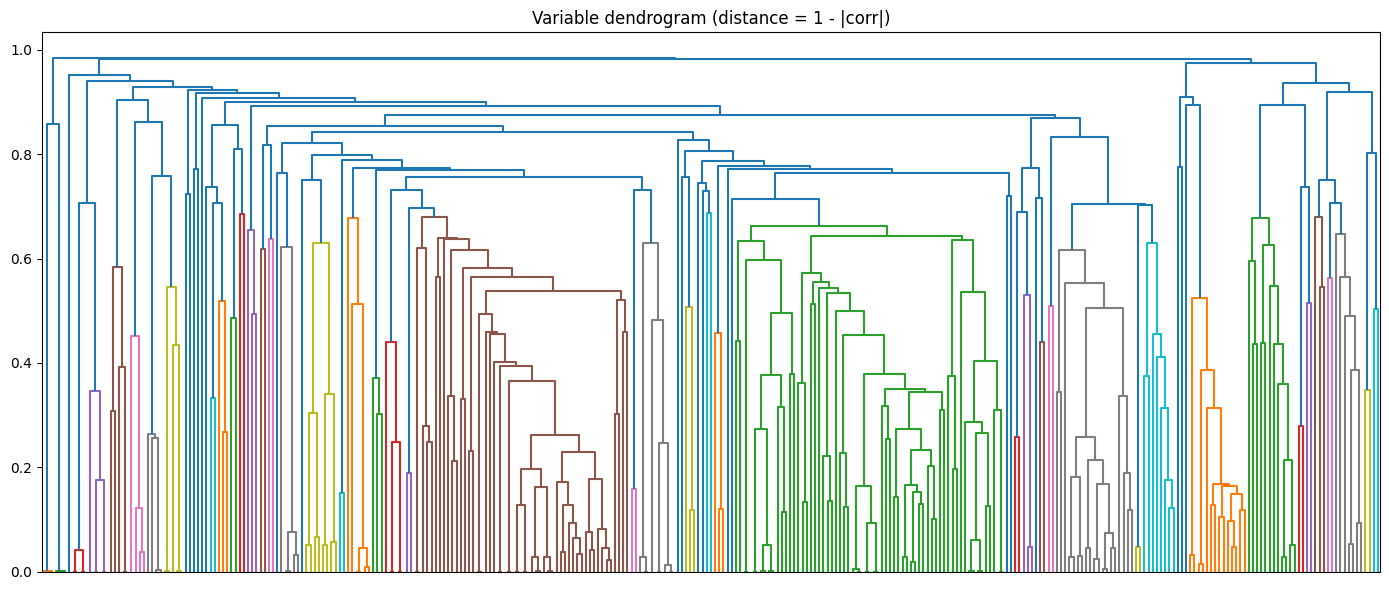

In [21]:
D = 1.0 - np.abs(C_pearson)

# Clean numerical issues
D = np.nan_to_num(D, nan=1.0, posinf=1.0, neginf=1.0)  # NaN -> max distance
D = np.clip(D, 0.0, 1.0)                               # <-- evita negativos
np.fill_diagonal(D, 0.0)                               # diagonal 0
# linkage requires condensed distance
Z = linkage(squareform(D, checks=False), method='average')

plt.figure(figsize=(14, 6))
dendrogram(Z, labels=feature_names_present, leaf_rotation=90, leaf_font_size=6, no_labels=True)
plt.title("Variable dendrogram (distance = 1 - |corr|)")
plt.tight_layout()
plt.show()


In [22]:
# Form clusters using a distance threshold equivalent to corr >= CORR_THRESH_STRONG
dist_thresh = 1.0 - CORR_THRESH_STRONG
clusters = fcluster(Z, t=dist_thresh, criterion='distance')
n_clusters = len(set(clusters))
print("Clusters at threshold:", n_clusters)

# Group features by cluster
cluster_members = defaultdict(list)
for idx, c in enumerate(clusters):
    cluster_members[c].append(idx)

# Show largest clusters
largest = sorted(cluster_members.items(), key=lambda kv: len(kv[1]), reverse=True)[:10]
for c, members in largest:
    print("Cluster", c, "size", len(members))
    for m in members[:10]:
        print("  -", feature_names_present[m])
    if len(members) > 10:
        print("  ...")


Clusters at threshold: 255
Cluster 3 size 4
  - Noraxon MyoMotion-Segments-Head-Rotation LT (deg)
  - Noraxon MyoMotion-Segments-Head-Rotation RT (deg)
  - Noraxon MyoMotion-Joints-Cervical-Axial LT (deg)
  - Cervical Axial - RT (deg)
Cluster 56 size 4
  - Noraxon MyoMotion-Segments-Upper arm RT-Rotation Ext (deg)
  - Noraxon MyoMotion-Segments-Forearm RT-Rotation Ext (deg)
  - Shoulder Rotation Ext RT (deg)
  - Noraxon MyoMotion-Joints-Shoulder RT-Rotation Int (deg)
Cluster 143 size 3
  - Pelvis roll (deg)
  - Pelvic Obliquity LT (deg)
  - Pelvic Obliquity RT (deg)
Cluster 106 size 3
  - Lower spine roll (deg)
  - Noraxon MyoMotion-Segments-Lower spine-Tilt Lat LT (deg)
  - Noraxon MyoMotion-Segments-Lower spine-Tilt Lat RT (deg)
Cluster 108 size 3
  - Upper spine roll (deg)
  - Noraxon MyoMotion-Segments-Upper spine-Tilt Lat LT (deg)
  - Noraxon MyoMotion-Segments-Upper spine-Tilt Lat RT (deg)
Cluster 85 size 3
  - Thigh pitch LT (deg)
  - Noraxon MyoMotion-Segments-Thigh LT-Tilt Fwd

## 8) Canonicalization rule (choose one representative per redundant cluster)

Rule (editable):
1. Prefer `Noraxon MyoMotion-...` names over generic ones.
2. Prefer joint angles (Flexion) over Extension sign-flips (but keep only one).
3. Prefer non-derived signals if both exist (e.g., Acceleration over Trajectory-derived).
4. Otherwise pick the first alphabetically.

This produces a **feature_map**: each feature -> canonical representative.


In [23]:
def score_feature_name(name: str) -> tuple:
    """Higher score means preferred."""
    # 1) Prefer Noraxon prefixed
    noraxon = 1 if name.startswith("Noraxon MyoMotion") else 0
    
    # 2) Prefer Flexion over Extension (choose one convention)
    flexion = 1 if "Flexion" in name else 0
    extension = 1 if "Extension" in name else 0
    
    # 3) Prefer Acceleration/Gyroscope over Trajectory if you want more direct IMU signals
    accel = 1 if "Acceleration" in name or "Accel" in name else 0
    gyro = 1 if "Gyroscope" in name else 0
    traj = 1 if "Trajectories" in name else 0
    
    # invert traj (less preferred)
    # Final tuple sorts lexicographically: higher is better
    return (noraxon, flexion, -extension, accel + gyro, -traj, -len(name), name)

def choose_representative(member_indices):
    names = [feature_names_present[i] for i in member_indices]
    best = sorted(names, key=score_feature_name, reverse=True)[0]
    return best

feature_map = {}
keep_set = set()

for c, members in cluster_members.items():
    if len(members) == 1:
        name = feature_names_present[members[0]]
        feature_map[name] = name
        keep_set.add(name)
        continue
    rep = choose_representative(members)
    keep_set.add(rep)
    for m in members:
        name = feature_names_present[m]
        feature_map[name] = rep

keep_features = sorted(list(keep_set))
print("Keep features:", len(keep_features), "of", len(feature_names_present))


Keep features: 255 of 321


In [24]:
# Build report table
rows = []
for name in feature_names_present:
    rows.append({
        "feature": name,
        "canonical": feature_map.get(name, name),
        "kept": (feature_map.get(name, name) == name) and (name in keep_set)
    })
report = pd.DataFrame(rows)
report['is_redundant'] = report['feature'] != report['canonical']

report['reason'] = "cluster_correlation"  # placeholder; can be enriched later

report.head(), report['is_redundant'].mean()


(                                             feature  \
 0                                               time   
 1                         Pelvis Accel Sensor X (mG)   
 2                         Pelvis Accel Sensor Y (mG)   
 3                         Pelvis Accel Sensor Z (mG)   
 4  Noraxon MyoMotion-Segments-Pelvis-Acceleration...   
 
                                            canonical   kept  is_redundant  \
 0                                               time   True         False   
 1  Noraxon MyoMotion-Segments-Pelvis-Acceleration...  False          True   
 2                         Pelvis Accel Sensor Y (mG)   True         False   
 3                         Pelvis Accel Sensor Z (mG)   True         False   
 4  Noraxon MyoMotion-Segments-Pelvis-Acceleration...   True         False   
 
                 reason  
 0  cluster_correlation  
 1  cluster_correlation  
 2  cluster_correlation  
 3  cluster_correlation  
 4  cluster_correlation  ,
 np.float64(0.205607476635514

## 9) Export artifacts (indices aligned to `DataBesa_Variables_names.txt`)

We export:
- feature names to keep
- indices to keep w.r.t. full list (FEATURE_NAMES)
- mapping and report


In [25]:
OUT_DIR = "./redundancy_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Indices in full FEATURE_NAMES order
full_name_to_idx = {n:i for i,n in enumerate(FEATURE_NAMES)}
keep_indices = np.array([full_name_to_idx[n] for n in keep_features if n in full_name_to_idx], dtype=int)

np.save(os.path.join(OUT_DIR, "keep_indices.npy"), keep_indices)

with open(os.path.join(OUT_DIR, "keep_features.txt"), "w", encoding="utf-8") as f:
    for n in keep_features:
        f.write(n + "\n")

with open(os.path.join(OUT_DIR, "feature_map.json"), "w", encoding="utf-8") as f:
    json.dump(feature_map, f, indent=2)

report.to_csv(os.path.join(OUT_DIR, "redundancy_report.csv"), index=False)

print("Saved:")
print(" -", os.path.join(OUT_DIR, "keep_indices.npy"))
print(" -", os.path.join(OUT_DIR, "keep_features.txt"))
print(" -", os.path.join(OUT_DIR, "feature_map.json"))
print(" -", os.path.join(OUT_DIR, "redundancy_report.csv"))


Saved:
 - ./redundancy_outputs/keep_indices.npy
 - ./redundancy_outputs/keep_features.txt
 - ./redundancy_outputs/feature_map.json
 - ./redundancy_outputs/redundancy_report.csv


## Visualization 

In [13]:
MI_matrix=np.load("MI_matrix.npy")
corr_pearson=np.load("corr_pearson.npy")
feature_names_present=json.load(open("feature_names_present.json")) 
print(corr_pearson.shape) 
print(len(feature_names_present)) #Load VIF results
with open("vif_all.json") as f:
    vifs = json.load(f)

#with open("vif_high.json") as f:
    #high_vif = json.load(f)
# Build distance matrix from correlation
D = 1.0 - np.abs(corr_pearson)

# Fix numerical issues
D = np.nan_to_num(D, nan=1.0, posinf=1.0, neginf=1.0)
D = np.clip(D, 0.0, 1.0)
np.fill_diagonal(D, 0.0)

# Hierarchical clustering
Z = linkage(squareform(D, checks=False), method="average")    

(321, 321)
321


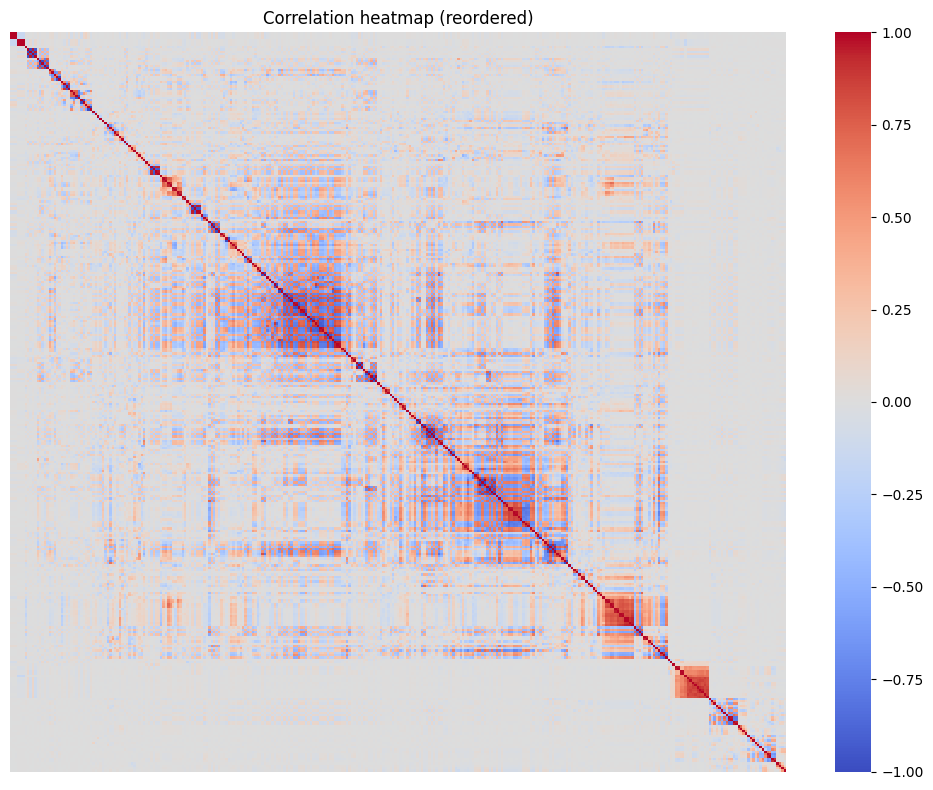

In [ ]:
# Correlation heatmap reordered by dendrogram
order = dendrogram(Z, no_plot=True)["leaves"]
C_ord = corr_pearson[np.ix_(order, order)]
names_ord = [feature_names_present[i] for i in order]

plt.figure(figsize=(10, 8))
sns.heatmap(
    C_ord,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    xticklabels=False,
    yticklabels=False
)
plt.title("Correlation heatmap (reordered)")
plt.tight_layout()
plt.show()


In [ ]:
# Variable selection 2D plot: Correlation vs Mutual Information 
print("Loading data files...")
try:
    corr_matrix = np.load("corr_pearson.npy")
    mi_matrix = np.load("MI_matrix.npy")
    feature_names = json.load(open("feature_names_present.json"))
    
    # Load VIF
    with open("vif_all.json") as f:
        vif_data = json.load(f)
        if isinstance(vif_data, list):
            vif_dict = {item['variable']: item['vif'] for item in vif_data}
        else:
            vif_dict = vif_data
except Exception as e:
    print(f"Error loading files: {e}")
    # Fallback to empty if files are missing (just for safety)
    raise

# --- 2. DATA PROCESSING ---
def clean_name(name):
    # Remove technical prefixes for cleaner visualization in the paper
    name = re.sub(r"Noraxon MyoMotion-(Segments|Joints|Trajectories)-", "", name)
    name = name.replace(" (deg)", "").replace(" (mm)", "").replace(" (mG)", "")
    return name

feature_names_clean = [clean_name(f) for f in feature_names]
n = len(feature_names)

# Threshold to reduce noise (show meaningful correlations only)
threshold = 0.5 
data_points = []

print(f"Processing pairs with Correlation > {threshold}...")

for i in range(n):
    for j in range(i+1, n):
        corr_val = corr_matrix[i, j]
        abs_corr = abs(corr_val)
        
        if abs_corr > threshold:
            name_a = feature_names[i]
            name_b = feature_names[j]
            clean_a = feature_names_clean[i]
            clean_b = feature_names_clean[j]
            
            # --- BIOMECHANICAL LOGIC ---
            # Identify Flexion vs Extension pairs (Vital for NONAN analysis)
            is_flex_ext = (("Flexion" in clean_a and "Extension" in clean_b) or 
                           ("Extension" in clean_a and "Flexion" in clean_b))
            
            # Categories for Decision Making
            if is_flex_ext:
                category = "Keep: Biomechanical Pair (Flex/Ext)"
                color_code = "green"
            elif abs_corr > 0.95:
                category = "Redundant: High Risk (>0.95)"
                color_code = "red"
            else:
                category = "Safe: Moderate Correlation"
                color_code = "blue"

            # VIF Handling (Size of the bubble)
            vif_a = vif_dict.get(name_a, 5)
            vif_b = vif_dict.get(name_b, 5)
            max_vif = max(vif_a, vif_b)
            # Cap visual size for extreme outliers
            if max_vif > 1000: max_vif = 100 

            data_points.append({
                "Pair": f"{clean_a} vs {clean_b}",
                "Correlation (Abs)": abs_corr,
                "Mutual Information": mi_matrix[i, j],
                "Max VIF": max_vif,
                "Category": category
            })

df_viz = pd.DataFrame(data_points)

# --- 3. GENERATE 2D PLOT (ENGLISH) ---
print(f"Generating plot with {len(df_viz)} pairs...")

fig = px.scatter(
    df_viz, 
    x="Correlation (Abs)", 
    y="Mutual Information",
    size="Max VIF",           # Bubble size indicates statistical danger (Multicollinearity)
    color="Category",         # Color indicates your decision
    hover_name="Pair",
    color_discrete_map={
        "Keep: Biomechanical Pair (Flex/Ext)": "#2ca02c",  # Green
        "Redundant: High Risk (>0.95)": "#d62728",         # Red
        "Safe: Moderate Correlation": "#1f77b4"            # Blue
    },
    title="<b>Variable Selection Map:</b> Correlation vs. Information Content",
    size_max=60 # Max bubble size
)

# Add Threshold Line
fig.add_vline(x=0.95, line_width=2, line_dash="dash", line_color="gray", annotation_text="Redundancy Threshold")

# English Labels & Layout
fig.update_layout(
    template="plotly_white",
    height=800,
    xaxis_title="Linear Correlation (Pearson Absolute)",
    yaxis_title="Non-Linear Information Content (Mutual Info)",
    legend=dict(
        title="Decision Category",
        yanchor="top", 
        y=0.99, 
        xanchor="left", 
        x=0.01, 
        bgcolor="rgba(255,255,255,0.9)",
        bordercolor="Black",
        borderwidth=1
    )
)

# Save and Show
output_file = "2D_Biomechanical_Decision_Plot.html"
fig.write_html(output_file)
print(f"Success! Interactive chart saved as '{output_file}'")
fig.show()

Loading data files...
Processing pairs with Correlation > 0.5...
Generating plot with 2175 pairs...
Success! Interactive chart saved as '2D_Biomechanical_Decision_Plot.html'


In [ ]:
# --- 3D PLOT: Correlation vs Mutual Information vs VIF ---
try:
    corr_matrix = np.load("corr_pearson.npy")
    mi_matrix = np.load("MI_matrix.npy") 
    feature_names = json.load(open("feature_names_present.json"))
    
    # Load VIF
    with open("vif_all.json") as f:
        vif_data = json.load(f)
        if isinstance(vif_data, list):
            vif_dict = {item['variable']: item['vif'] for item in vif_data}
        else:
            vif_dict = vif_data
            
except Exception as e:
    print(f"Error loading files: {e}")
    print("Please check that 'corr_pearson.npy', 'MI_matrix.npy', and 'vif_all.json' are in the current directory.")
    # Stop execution if data is missing
    raise

# 2. DATA CLEANING & PROCESSING
def clean_name(name):
    # Remove technical prefixes for cleaner visualization
    name = re.sub(r"Noraxon MyoMotion-(Segments|Joints|Trajectories)-", "", name)
    name = name.replace(" (deg)", "").replace(" (mm)", "").replace(" (mG)", "")
    return name

feature_names_clean = [clean_name(f) for f in feature_names]
n = len(feature_names)

# Visual Threshold: Only show pairs with some correlation to avoid cluttering the 3D space
# We use 0.6 to capture moderate relationships too
threshold = 0.6 
data_points = []

print(f"Processing {n} variables. Filtering pairs with Correlation > {threshold}...")

for i in range(n):
    for j in range(i+1, n):
        # Pearson Correlation (Absolute value for magnitude)
        corr_val = corr_matrix[i, j]
        abs_corr = abs(corr_val)
        
        if abs_corr > threshold:
            name_a = feature_names[i]
            name_b = feature_names[j]
            clean_a = feature_names_clean[i]
            clean_b = feature_names_clean[j]
            
            # Mutual Information (Non-linear dependency)
            mi_val = mi_matrix[i, j]
            
            # VIF (Multicollinearity risk) - Take the worst of the pair
            vif_a = vif_dict.get(name_a, 1)
            vif_b = vif_dict.get(name_b, 1)
            max_vif = max(vif_a, vif_b)
            
            # --- DECISION LOGIC (BIOMECHANICS) ---
            # Identify Flexion vs Extension pairs
            is_flex_ext = (("Flexion" in clean_a and "Extension" in clean_b) or 
                           ("Extension" in clean_a and "Flexion" in clean_b))
            
            # Categorize
            if is_flex_ext:
                category = "Keep: Biomechanical Pair (Flex/Ext)"
                size_marker = 15 # Make them visible
            elif abs_corr > 0.95:
                category = "Redundant: High Risk (>0.95)"
                size_marker = 10
            else:
                category = "Safe: Moderate Correlation"
                size_marker = 5

            data_points.append({
                "Pair": f"{clean_a} vs {clean_b}",
                "Abs Correlation": abs_corr,
                "Mutual Information": mi_val,
                "Max VIF": max_vif,
                "Category": category,
                "Size": size_marker
            })

df_viz = pd.DataFrame(data_points)
print(f"Found {len(df_viz)} pairs to visualize.")

# 3. GENERATE 3D PLOT
fig = px.scatter_3d(
    df_viz,
    x='Abs Correlation',
    y='Mutual Information',
    z='Max VIF',
    color='Category',
    size='Size', # Use fixed sizes or mapped sizes
    hover_name='Pair',
    color_discrete_map={
        "Keep: Biomechanical Pair (Flex/Ext)": "#00CC96", # Green (Good)
        "Redundant: High Risk (>0.95)": "#EF553B",        # Red (Bad)
        "Safe: Moderate Correlation": "#636EFA"           # Blue (Neutral)
    },
    title="<b>3D Redundancy Analysis:</b> Pearson vs. Mutual Info vs. VIF",
    opacity=0.8
)

# Update layout for better 3D experience
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
    scene=dict(
        xaxis_title='Linear Correlation (Pearson)',
        yaxis_title='Information Content (Mutual Info)',
        zaxis_title='Multicollinearity (VIF)',
        xaxis=dict(backgroundcolor="rgb(240, 240, 240)"),
        yaxis=dict(backgroundcolor="rgb(240, 240, 240)"),
        zaxis=dict(backgroundcolor="rgb(230, 230, 230)"),
    ),
    legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.05)
)

# Save and Show
output_file = "3D_Biomechanical_Decision_Plot.html"
fig.write_html(output_file)
print(f"Success! Open '{output_file}' in your browser to interact.")
fig.show()

Loading data files...
Processing 321 variables. Filtering pairs with Correlation > 0.6...
Found 1197 pairs to visualize.
Success! Open '3D_Biomechanical_Decision_Plot.html' in your browser to interact.


# FKGs on Cycles

In [4]:
#Imports 
import torch
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from AE_pipeline_pytorch import SemiSupAE, GaitBatchIterable, device
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import json 

Using device: cuda


In [5]:
#Load the model from the checkpoint
ckpt_path = Path("runs/semisup_3groups_20251119_124802/semisupae_last.pt")
ckpt = torch.load(ckpt_path, map_location=device)

model = SemiSupAE(
        steps=100,
        in_dim=321,
        latent=128,
        n_group=3,
        n_nuisance=None,
    ).to(device)

model.load_state_dict(ckpt["model"])   
model.eval()

SemiSupAE(
  (encoder): BiLSTMEncoder(
    (bilstm): LSTM(321, 128, batch_first=True, bidirectional=True)
    (to_latent): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): LSTMDecoder(
    (init): Linear(in_features=128, out_features=128, bias=True)
    (lstm): LSTM(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=321, bias=True)
  )
  (group_head): HeadMLP(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (proj_head): ProjectionHead(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)

In [6]:
# test Dataloader with meta info and cycle id 
test_path = "test_cycles.zarr"
accum_steps = 1
micro_batch = 2048
num_workers = 1
prefetch = 1

test_loader = DataLoader(
    GaitBatchIterable(test_path, batch_size=micro_batch, return_meta=True, shuffle=False, seed=SEED),
    batch_size=None,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=prefetch,
    drop_last=False,
)

# Get one batch to inspect what the loader returns
batch = next(iter(test_loader))

if isinstance(batch, (list, tuple)) and len(batch) == 3:
    x_example, meta_example, cycle_id_example = batch
elif isinstance(batch, (list, tuple)) and len(batch) == 2:
    x_example, meta_example = batch
    cycle_id_example = None
else:
    x_example, meta_example, cycle_id_example = batch, None, None

print("x:", x_example.shape)
print("meta:", None if meta_example is None else meta_example.shape)
print("cycle_id:", None if cycle_id_example is None else cycle_id_example.shape)

if isinstance(meta_example, dict):
    print("meta keys:", meta_example.keys())
elif isinstance(meta_example, torch.Tensor):
    print("meta_example shape:", meta_example.shape)

# Check model output
x_example = x_example.to(device)
with torch.no_grad():
    out_example = model(x_example, return_all=True)

x: torch.Size([2048, 100, 321])
meta: torch.Size([2048, 100, 5])
cycle_id: torch.Size([2048])
meta_example shape: torch.Size([2048, 100, 5])


In [5]:
# Helper function to compute MI matrix
def compute_mi_matrix(X, n_samples=None, seed=0):
    rng = np.random.default_rng(seed)
    T, F = X.shape

    idx = np.arange(T)
    if n_samples is not None and T > n_samples:
        idx = rng.choice(idx, size=n_samples, replace=False)

    Xs = X[idx, :]

    MI = np.zeros((F, F), dtype=np.float64)
    for i in range(F):
        for j in range(i + 1, F):
            mi = mutual_info_regression(
                Xs[:, [i]], Xs[:, j],
                discrete_features=False,
                random_state=seed
            )[0]
            MI[i, j] = MI[j, i] = mi

    return MI



In [6]:
#DONT RUN AGAIN: Calculation of Correlation and MI matrices on a random subset of test data 
# (can be time-consuming; save results to .npy files for reuse)

F = 321 #Including time 
T_EXPECTED = 100
N_POINTS_TARGET = 300_000   # Adjust based on memory/time constraints
SEED = 0
rng = np.random.default_rng(SEED)

def to_BTF(x, F=321):
    if x.ndim != 3:
        raise ValueError(f"Expected 3D tensor, got {x.shape}")
    B, A, C = x.shape
    if C == F:
        return x  # (B,T,F)
    if A == F:
        return x.permute(0,2,1).contiguous()  # (B,F,T)->(B,T,F)
    raise ValueError(f"Cannot infer F= {F} from {x.shape}")

chunks = []
total_points = 0

for batch in test_loader:
    x, meta = batch if (isinstance(batch, (list, tuple)) and len(batch) > 1) else (batch, None)
    x = to_BTF(x, F=F)                       # (B,T,F)
    x = x.detach().cpu().numpy().astype(np.float32)

    B, T, _ = x.shape
    if T != T_EXPECTED:
        print("Warning: T != 100. Got", T)

    # keep a random subset of cycles from this batch
    # choose keep_prob dynamically so we stop near target
    remaining = max(N_POINTS_TARGET - total_points, 0)
    if remaining <= 0:
        break

    # expected points per cycle = T
    # cycles needed ~ remaining/T
    cycles_needed = int(np.ceil(remaining / T))
    keep_prob = np.clip(cycles_needed / max(B, 1), 0.01, 1.0)

    keep_mask = rng.random(B) < keep_prob
    idx = np.where(keep_mask)[0]
    if idx.size == 0:
        continue

    x_kept = x[idx]                 # (b_keep,T,F)
    x_pts  = x_kept.reshape(-1, F)  # (b_keep*T,F)

    chunks.append(x_pts)
    total_points += x_pts.shape[0]

X_sample = np.vstack(chunks)
X_sample = X_sample[:N_POINTS_TARGET]
print("X_sample:", X_sample.shape)   # (N_POINTS_TARGET, 321)

# Pearson (on standardized)
X_std = StandardScaler().fit_transform(np.nan_to_num(X_sample, nan=0.0, posinf=0.0, neginf=0.0))
C_pearson = np.corrcoef(X_std, rowvar=False)
np.save("corr_pearson_test_sample.npy", C_pearson)

# Spearman
C_spearman, _ = spearmanr(X_sample, axis=0)
C_spearman = np.array(C_spearman, dtype=np.float64)
np.save("corr_spearman_test_sample.npy", C_spearman)

# MI (using your function)
MI = compute_mi_matrix(X_sample, n_samples=None, seed=SEED)
np.save("MI_test_sample.npy", MI)

print("Saved: corr_pearson_test_sample.npy, corr_spearman_test_sample.npy, MI_test_sample.npy")


KeyboardInterrupt: 

In [7]:
# Load the Correlation and MI matrices 
C_spearman = np.load("corr_spearman_test_sample.npy")
MI = np.load("MI_test_sample.npy")
C_spearman.shape, MI.shape


((321, 321), (321, 321))

In [8]:
# Function to B2-B4 Create FKG edges based on correlation and MI 
# B2) Build variable graph edges
# -----------------------------
def build_variable_graph_edges(C_spearman, MI, feature_names,
                               rho_thr=0.88, mi_percentile=95,
                               max_edges=120_000):
    """
    Returns:
      edges: list of (i, j, weight, reason)
      mi_thr: MI threshold used (percentile)
    """
    F = C_spearman.shape[0]
    assert MI.shape == (F, F)

    # Use upper triangle MI values to set threshold
    mi_vals = MI[np.triu_indices(F, k=1)]
    mi_thr = np.percentile(mi_vals, mi_percentile)

    edges = []
    for i in range(F):
        for j in range(i + 1, F):
            rho = float(C_spearman[i, j])
            mi = float(MI[i, j])

            # Rule 1: strong (monotonic) correlation => edge
            if abs(rho) >= rho_thr:
                # weight can emphasize stronger coupling; keep simple
                w = max(abs(rho), 1e-6)
                edges.append((i, j, w, f"rho|>= {rho_thr:.2f} (rho={rho:.3f})"))
                continue

            # Rule 2: high MI but not strongly correlated => non-linear-ish edge
            if mi >= mi_thr:
                # MI weights can dwarf rho; normalize MI to [0,1] roughly by percentile scale
                w = max(mi / (mi_thr + 1e-12), 1e-6)
                edges.append((i, j, w, f"MI>=p{mi_percentile} (MI={mi:.3f}, rho={rho:.3f})"))

    # Optional: cap edges to avoid overly dense graph
    if max_edges is not None and len(edges) > max_edges:
        # Sort by weight descending and keep top edges
        edges = sorted(edges, key=lambda t: t[2], reverse=True)[:max_edges]

    print(f"[B2] MI threshold @ p{mi_percentile} = {mi_thr:.6f}")
    print(f"[B2] Built edges: {len(edges)} (rho_thr={rho_thr}, mi_percentile={mi_percentile})")
    return edges, mi_thr


# -----------------------------
# B3) Community detection (variable grouping)
# -----------------------------
def cluster_variables_from_edges(edges, F, feature_names,
                                 method="louvain",
                                 min_group_size=3):
    """
    Returns:
      groups: list of lists of feature indices
      G: networkx graph
    """
    import networkx as nx

    G = nx.Graph()
    G.add_nodes_from(range(F))

    for (i, j, w, reason) in edges:
        # Use weight for modularity
        G.add_edge(i, j, weight=float(w), reason=reason)

    # If graph is too sparse, you'll get many singletons
    n_edges = G.number_of_edges()
    print(f"[B3] Graph nodes={G.number_of_nodes()}, edges={n_edges}")

    # Louvain if available; else fallback
    communities = None
    if method.lower() == "louvain":
        try:
            from networkx.algorithms.community import louvain_communities
            communities = louvain_communities(G, weight="weight", seed=0)
            print("[B3] Using networkx louvain_communities")
        except Exception as e:
            print("[B3] Louvain not available in your networkx version. Falling back to greedy_modularity_communities.")
            from networkx.algorithms.community import greedy_modularity_communities
            communities = list(greedy_modularity_communities(G, weight="weight"))
    elif method.lower() == "greedy":
        from networkx.algorithms.community import greedy_modularity_communities
        communities = list(greedy_modularity_communities(G, weight="weight"))
        print("[B3] Using greedy_modularity_communities")
    else:
        raise ValueError("method must be 'louvain' or 'greedy'")

    # Convert to sorted lists
    groups = [sorted(list(c)) for c in communities]

    # Separate singletons / small groups
    big_groups = [g for g in groups if len(g) >= min_group_size]
    small_groups = [g for g in groups if len(g) < min_group_size]

    print(f"[B3] Communities total={len(groups)} | >= {min_group_size}: {len(big_groups)} | small: {len(small_groups)}")
    return big_groups, small_groups, G


# -----------------------------
# Helpers for B4) Group validation
# -----------------------------
def group_stats(group, C_spearman, MI):
    """Return summary stats for within-group rho and MI."""
    idx = np.array(group, dtype=int)
    if len(idx) < 2:
        return dict(n=len(idx), rho_mean=np.nan, rho_median=np.nan, rho_p90=np.nan,
                    mi_mean=np.nan, mi_median=np.nan, mi_p90=np.nan)

    # Upper triangle within group
    sub_rho = C_spearman[np.ix_(idx, idx)]
    sub_mi = MI[np.ix_(idx, idx)]
    tri = np.triu_indices(len(idx), k=1)

    rho_vals = np.abs(sub_rho[tri])
    mi_vals = sub_mi[tri]

    return dict(
        n=len(idx),
        rho_mean=float(np.mean(rho_vals)),
        rho_median=float(np.median(rho_vals)),
        rho_p90=float(np.percentile(rho_vals, 90)),
        mi_mean=float(np.mean(mi_vals)),
        mi_median=float(np.median(mi_vals)),
        mi_p90=float(np.percentile(mi_vals, 90)),
    )


def compute_group_vif(X, group, eps=1e-12):
    """
    Compute VIF for variables in 'group' using statsmodels.
    Returns dict: {feature_index: vif_value}
    """
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    idx = np.array(group, dtype=int)
    Xg = X[:, idx]

    # Replace NaN/inf, add tiny noise to constant columns to avoid singularities
    Xg = np.nan_to_num(Xg, nan=0.0, posinf=0.0, neginf=0.0)

    # Drop near-constant columns (VIF undefined); mark them as inf
    col_std = Xg.std(axis=0)
    near_const = col_std < eps

    # Add intercept for VIF calculation consistency
    Xg2 = sm.add_constant(Xg, has_constant="add")

    vifs = {}
    # variance_inflation_factor expects array without NaNs
    for k, fi in enumerate(idx):
        if near_const[k]:
            vifs[int(fi)] = float("inf")
        else:
            # +1 because const column at 0
            vifs[int(fi)] = float(variance_inflation_factor(Xg2, k + 1))

    return vifs


# -----------------------------
# B4) Validate / filter groups
# -----------------------------
def validate_groups(groups, X_raw, C_spearman, MI, feature_names,
                    min_group_size=3,
                    min_rho_median=0.50,     # "redundancy-ish"
                    min_mi_median=None,      # if None: computed as global MI percentile 75
                    max_vif_median=None,     # optional upper bound (rarely needed)
                    min_vif_median=5.0,      # interpret as meaningful multicollinearity/redundancy
                    mi_reference_percentile=75):
    """
    Returns:
      valid_groups: list of dicts with group info
      rejected_groups: list of dicts with reasons
    """
    F = C_spearman.shape[0]
    assert len(feature_names) == F

    # If MI median threshold not provided, choose global MI percentile as reference
    if min_mi_median is None:
        mi_vals = MI[np.triu_indices(F, k=1)]
        min_mi_median = float(np.percentile(mi_vals, mi_reference_percentile))
        print(f"[B4] min_mi_median set to global MI p{mi_reference_percentile} = {min_mi_median:.6f}")

    valid_groups = []
    rejected_groups = []

    for g in groups:
        info = {}
        info["size"] = len(g)
        info["indices"] = g
        info["names"] = [feature_names[i] for i in g]

        if len(g) < min_group_size:
            info["reject_reason"] = f"size < {min_group_size}"
            rejected_groups.append(info)
            continue

        stats = group_stats(g, C_spearman, MI)
        info.update(stats)

        # Compute VIFs
        try:
            vifs = compute_group_vif(X_raw, g)
            vif_vals = np.array([vifs[i] for i in g], dtype=float)
            # robust summaries
            info["vif_median"] = float(np.median(vif_vals[np.isfinite(vif_vals)])) if np.any(np.isfinite(vif_vals)) else float("inf")
            info["vif_p90"] = float(np.percentile(vif_vals[np.isfinite(vif_vals)], 90)) if np.any(np.isfinite(vif_vals)) else float("inf")
        except Exception as e:
            # If VIF fails, don't kill the pipeline; mark and continue using rho/mi only
            info["vif_median"] = np.nan
            info["vif_p90"] = np.nan
            info["vif_error"] = str(e)

        # Acceptance logic:
        # - either it is clearly redundant linearly (rho median high) OR nonlinearly coupled (MI median high),
        # - and VIF indicates multicollinearity (if available)
        ok_redundancy = (info["rho_median"] >= min_rho_median) or (info["mi_median"] >= min_mi_median)

        ok_vif = True
        if not np.isnan(info["vif_median"]):
            ok_vif = (info["vif_median"] >= min_vif_median)
            if (max_vif_median is not None) and np.isfinite(info["vif_median"]):
                ok_vif = ok_vif and (info["vif_median"] <= max_vif_median)

        if ok_redundancy and ok_vif:
            info["status"] = "VALID"
            valid_groups.append(info)
        else:
            reasons = []
            if not ok_redundancy:
                reasons.append(f"rho_median<{min_rho_median} and mi_median<{min_mi_median:.6f}")
            if not ok_vif:
                reasons.append(f"vif_median<{min_vif_median}")
            info["reject_reason"] = " | ".join(reasons)
            rejected_groups.append(info)

    # Sort valid groups by size desc then rho_median desc
    valid_groups = sorted(valid_groups, key=lambda d: (d["size"], d.get("rho_median", 0.0)), reverse=True)

    print(f"[B4] Valid groups: {len(valid_groups)} | Rejected: {len(rejected_groups)}")
    return valid_groups, rejected_groups




In [9]:
# check feature names file
names_path = Path("DataBesa_Variables_names.txt")

# 1) Read lines, strip whitespace, drop empties
names = [ln.strip() for ln in names_path.read_text(encoding="utf-8", errors="ignore").splitlines()]
names = [n for n in names if n != ""]

print("Raw names:", len(names))
print("First 5:", names[:5])

F = 321
if len(names) != F:
    raise ValueError(f"Expected {F} names, got {len(names)}. First 10: {names[:10]}")
feature_names_present_all = names   # aquí incluye time en posición 0
assert feature_names_present_all[0].lower() == "time"
time_idx = 0
print("feature_names_present ready:", len(feature_names_present_all))
print("Last 5:", feature_names_present_all[-5:])


Raw names: 321
First 5: ['time', 'Pelvis Accel Sensor X (mG)', 'Pelvis Accel Sensor Y (mG)', 'Pelvis Accel Sensor Z (mG)', 'Noraxon MyoMotion-Segments-Pelvis-Acceleration-x (mG)']
feature_names_present ready: 321
Last 5: ['Noraxon MyoMotion-Trajectories-Pelvis-y (mm)', 'Noraxon MyoMotion-Trajectories-Heel LT-x (mm)', 'Noraxon MyoMotion-Trajectories-Heel LT-y (mm)', 'Noraxon MyoMotion-Trajectories-Heel RT-x (mm)', 'Noraxon MyoMotion-Trajectories-Heel RT-y (mm)']


In [10]:
# Remove 'time' from feature names & X_raw & X_sample
X_raw = np.load("X_raw.npy")
# Remove from raw matrices
X_raw_nt = np.delete(X_raw, time_idx, axis=1)

# Si tienes X_sample / X_vif
#X_sample = np.delete(X_sample, time_idx, axis=1)
#X_vif    = np.delete(X_vif, time_idx, axis=1)


valid_idx = [i for i, name in enumerate(feature_names_present_all) if name != "time"]
C_spearman_nt = C_spearman[np.ix_(valid_idx, valid_idx)]
MI_nt = MI[np.ix_(valid_idx, valid_idx)]
feature_names_nt = [feature_names_present_all[i] for i in valid_idx]
F = C_spearman_nt.shape[0]

print("C_spearman_nt:", C_spearman_nt.shape, "MI_nt:", MI_nt.shape, "X_raw_nt:", X_raw_nt.shape, "len(names)_nt:", len(feature_names_nt))


C_spearman_nt: (320, 320) MI_nt: (320, 320) X_raw_nt: (1980045, 320) len(names)_nt: 320


In [11]:
assert C_spearman_nt.shape == MI_nt.shape
assert C_spearman_nt.shape[0] == X_raw_nt.shape[1] == len(feature_names_nt)


In [12]:
# RUN B2-B4 Build the FKG and validate groups
# -----------------------------
# B2
edges, mi_thr = build_variable_graph_edges(
    C_spearman=C_spearman_nt,
    MI=MI_nt,
    feature_names=feature_names_nt,
    rho_thr=0.9,
    mi_percentile=97,
    max_edges=120_000
)

# B3
big_groups, small_groups, G = cluster_variables_from_edges(
    edges=edges,
    F=F,
    feature_names=feature_names_nt,
    method="louvain",        # or "greedy"
    min_group_size=4
)

# B4
valid_groups, rejected_groups = validate_groups(
    groups=big_groups,
    X_raw=X_raw_nt,
    C_spearman=C_spearman_nt,
    MI=MI_nt,
    feature_names=feature_names_nt,
    min_group_size=4,
    min_rho_median=0.55,
    min_mi_median=None,          # auto from MI global percentile
    min_vif_median=6.0,
    mi_reference_percentile=80
)

# Save results (recommended)
df_valid = pd.DataFrame([{
    "group_id": k,
    "size": g["size"],
    "rho_median": g["rho_median"],
    "rho_p90": g["rho_p90"],
    "mi_median": g["mi_median"],
    "mi_p90": g["mi_p90"],
    "vif_median": g.get("vif_median", np.nan),
    "vif_p90": g.get("vif_p90", np.nan),
    "features": "; ".join(g["names"])
} for k, g in enumerate(valid_groups)])

df_rej = pd.DataFrame([{
    "size": g.get("size", None),
    "reject_reason": g.get("reject_reason", ""),
    "features": "; ".join(g.get("names", []))
} for g in rejected_groups])

df_valid.to_csv("FKG_valid_groups.csv", index=False)
df_rej.to_csv("FKG_rejected_groups.csv", index=False)
print("Saved: FKG_valid_groups.csv, FKG_rejected_groups.csv")

# Quick print top groups
print("\nTop VALID groups:")
for k, g in enumerate(valid_groups[:10]):
    print(f"\n[Group {k}] size={g['size']} | rho_med={g['rho_median']:.3f} | mi_med={g['mi_median']:.3f} | vif_med={g.get('vif_median', np.nan)}")
    for name in g["names"][:15]:
        print("  -", name)
    if g["size"] > 15:
        print("  ...")


[B2] MI threshold @ p97 = 0.788003
[B2] Built edges: 1532 (rho_thr=0.9, mi_percentile=97)
[B3] Graph nodes=320, edges=1532
[B3] Using networkx louvain_communities
[B3] Communities total=142 | >= 4: 6 | small: 136
[B4] min_mi_median set to global MI p80 = 0.325581


/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[B4] Valid groups: 6 | Rejected: 0
Saved: FKG_valid_groups.csv, FKG_rejected_groups.csv

Top VALID groups:

[Group 0] size=62 | rho_med=0.353 | mi_med=0.614 | vif_med=9.87459514590001
  - Pelvis roll (deg)
  - Pelvic Obliquity LT (deg)
  - Pelvic Obliquity RT (deg)
  - Noraxon MyoMotion-Segments-Upper arm LT-Gyroscope-y (deg/s)
  - Noraxon MyoMotion-Segments-Upper arm LT-Gyroscope-z (deg/s)
  - Noraxon MyoMotion-Segments-Forearm LT-Gyroscope-y (deg/s)
  - Noraxon MyoMotion-Segments-Forearm LT-Gyroscope-z (deg/s)
  - Noraxon MyoMotion-Segments-Hand LT-Gyroscope-y (deg/s)
  - Noraxon MyoMotion-Segments-Hand LT-Gyroscope-z (deg/s)
  - Thigh Accel Sensor X LT (mG)
  - Noraxon MyoMotion-Segments-Thigh LT-Acceleration-z (mG)
  - Noraxon MyoMotion-Segments-Thigh LT-Gyroscope-y (deg/s)
  - Noraxon MyoMotion-Segments-Thigh LT-Tilt Med (deg)
  - Noraxon MyoMotion-Segments-Thigh LT-Rotation Ext (deg)
  - Noraxon MyoMotion-Segments-Shank LT-Gyroscope-y (deg/s)
  ...

[Group 1] size=52 | rho_med=0.

See how the use of each FKG changes in the latent space and in the clusters

In [13]:
def build_fkg_from_valid_csv_and_feature_names(
    csv_path: str,
    feature_names_nt,
    features_col: str = "features",
    group_id_col: str = "group_id",
    delimiter: str = ";"
):
    # feature_names_nt: list[str] length F (here F=320)
    feature_names_nt = list(feature_names_nt)
    name_to_idx = {name: i for i, name in enumerate(feature_names_nt)}

    df = pd.read_csv(csv_path)
    if group_id_col not in df.columns:
        raise ValueError(f"CSV missing '{group_id_col}' column. Found: {df.columns.tolist()}")
    if features_col not in df.columns:
        raise ValueError(f"CSV missing '{features_col}' column. Found: {df.columns.tolist()}")

    # Sort by group_id to keep stable ordering
    df = df.sort_values(group_id_col).reset_index(drop=True)

    FKG_indices = []
    FKG_names = []
    missing_report = {}

    for _, row in df.iterrows():
        gid = int(row[group_id_col])
        feats_str = str(row[features_col]) if pd.notna(row[features_col]) else ""
        # Split and strip
        feat_names = [s.strip() for s in feats_str.split(delimiter) if s.strip()]

        idxs = []
        missing = []
        for nm in feat_names:
            if nm in name_to_idx:
                idxs.append(name_to_idx[nm])
            else:
                # Try simple normalization (common culprits)
                nm2 = " ".join(nm.split())  # collapse multiple spaces
                if nm2 in name_to_idx:
                    idxs.append(name_to_idx[nm2])
                else:
                    missing.append(nm)

        idxs = sorted(set(idxs))
        FKG_indices.append(idxs)

        # A readable name: keep as FKG_<gid> (size=K)
        FKG_names.append(f"FKG_{gid}_K{len(idxs)}")

        if missing:
            missing_report[gid] = missing

    n_fkg = len(FKG_indices)

    # Sanity checks
    if n_fkg == 0:
        raise RuntimeError("No FKG groups loaded. Check CSV content.")
    if any(len(idxs) == 0 for idxs in FKG_indices):
        empty = [i for i, idxs in enumerate(FKG_indices) if len(idxs) == 0]
        raise RuntimeError(f"Some FKGs ended up empty after name->index mapping: {empty}. "
                           f"Likely feature-name mismatch between CSV and feature_names_nt.")

    # Range check
    F = len(feature_names_nt)
    for gi, idxs in enumerate(FKG_indices):
        if min(idxs) < 0 or max(idxs) >= F:
            raise ValueError(f"FKG {gi} has out-of-range indices. min={min(idxs)}, max={max(idxs)}, F={F}")

    print(f"Built {n_fkg} FKGs from {csv_path}. Feature space size F={len(feature_names_nt)}.")
    if missing_report:
        total_missing = sum(len(v) for v in missing_report.values())
        print(f"WARNING: {total_missing} feature-names were not found in feature_names_nt.")
        # Show a few
        for gid, miss in list(missing_report.items())[:3]:
            print(f"  - group {gid}: missing examples -> {miss[:5]}")
        print("If this is non-zero, check for naming inconsistencies (spaces, LT/RT tags, etc.).")

    return FKG_indices, FKG_names, n_fkg, missing_report





In [14]:
# --- FKG BUILDING: Load the valid groups CSV and convert to FKG format ---
FKG_indices, FKG_names, n_fkg, missing_report = build_fkg_from_valid_csv_and_feature_names(
    csv_path="FKG_valid_groups.csv",
    feature_names_nt=feature_names_nt,
    features_col="features",
    group_id_col="group_id",
    delimiter=";"
)

print("n_fkg =", n_fkg)
print("Example FKG 0:", FKG_names[0], "size", len(FKG_indices[0]), "idx range", (min(FKG_indices[0]), max(FKG_indices[0])))

Built 6 FKGs from FKG_valid_groups.csv. Feature space size F=320.
n_fkg = 6
Example FKG 0: FKG_0_K62 size 62 idx range (11, 311)


In [15]:
def fkg_activation_var_ratio(x_cycle_nt, fkg_idxs, eps=1e-12):
    """
    x_cycle_nt: (T, F) with F=320 (no time), ideally globally standardized
    returns: scalar in [0, +inf), typically 0..1-ish if standardized
    """
    Xf = x_cycle_nt[:, fkg_idxs]
    Xall = x_cycle_nt
    vf = np.var(Xf, axis=0).mean()
    va = np.var(Xall, axis=0).mean()
    return float(vf / (va + eps))


In [16]:
def fkg_activation_mean_abs_corr(x_cycle_nt, fkg_idxs, eps=1e-12):
    """
    Mean absolute correlation within the FKG across time.
    Needs T>=~50. With T=100 it is ok-ish.
    """
    Xf = x_cycle_nt[:, fkg_idxs]  # (T, K)
    Xf = np.nan_to_num(Xf, nan=0.0, posinf=0.0, neginf=0.0)

    # If K==1, correlation undefined -> return 0 (no coordination info)
    K = Xf.shape[1]
    if K < 2:
        return 0.0

    C = np.corrcoef(Xf, rowvar=False)  # (K,K)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)

    # mean abs off-diagonal
    absC = np.abs(C)
    off = absC[~np.eye(K, dtype=bool)]
    return float(off.mean() if off.size else 0.0)


In [17]:
def fkg_activation_pc1_ratio(x_cycle_nt, fkg_idxs, eps=1e-12):
    """
    Ratio of variance explained by PC1 inside FKG.
    High -> block moves as 1D rigid synergy.
    """
    Xf = x_cycle_nt[:, fkg_idxs]
    Xf = np.nan_to_num(Xf, nan=0.0, posinf=0.0, neginf=0.0)
    Xf = Xf - Xf.mean(axis=0, keepdims=True)

    K = Xf.shape[1]
    if K < 2:
        return 1.0  # trivial

    # SVD of T x K
    _, s, _ = np.linalg.svd(Xf, full_matrices=False)
    var = (s**2)
    return float(var[0] / (var.sum() + eps))


A: (61142, 6) labels: (61142,) groups: (61142,) metric: pc1_ratio
Saved: cluster_x_FKG_activation_pc1_ratio.csv
Saved: cluster_x_FKG_activation_pc1_ratio_zscore.csv


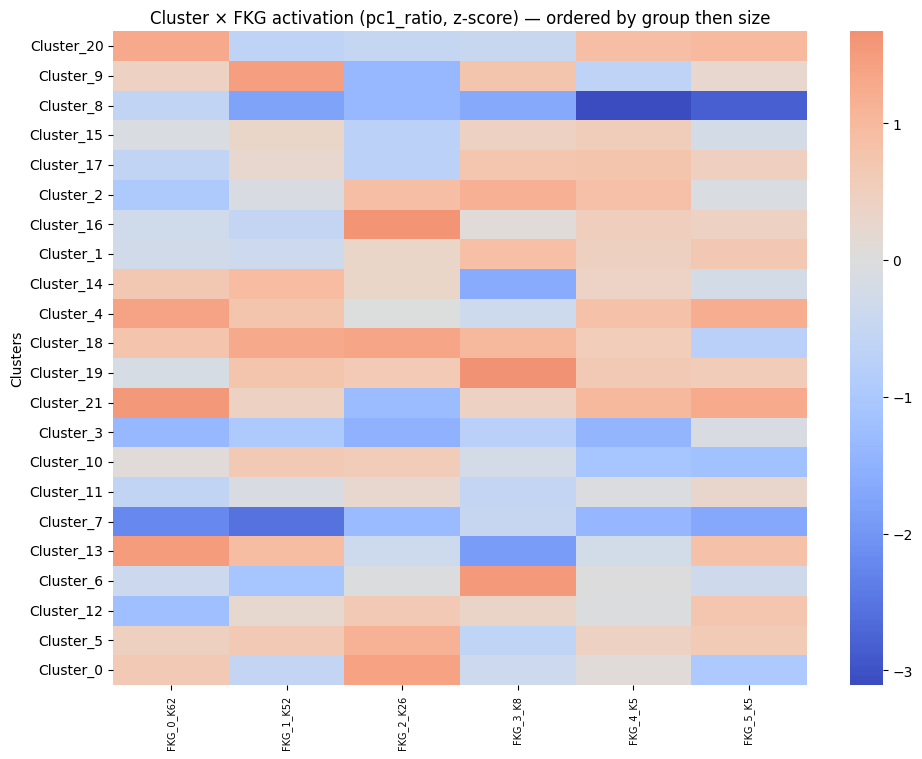

In [18]:
# FKG 

# -------------------------
# Choose metric
# -------------------------
METRIC = "pc1_ratio"   # "rms", "var_ratio", "mean_abs_corr", "pc1_ratio"

def fkg_activation_var_ratio(x_cycle_nt, fkg_idxs, eps=1e-12):
    Xf = x_cycle_nt[:, fkg_idxs]
    Xall = x_cycle_nt
    Xf = np.nan_to_num(Xf, nan=0.0, posinf=0.0, neginf=0.0)
    Xall = np.nan_to_num(Xall, nan=0.0, posinf=0.0, neginf=0.0)
    vf = np.var(Xf, axis=0).mean()
    va = np.var(Xall, axis=0).mean()
    return float(vf / (va + eps))

def fkg_activation_mean_abs_corr(x_cycle_nt, fkg_idxs):
    X = x_cycle_nt[:, fkg_idxs]
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    K = X.shape[1]
    if K < 2:
        return 0.0
    C = np.corrcoef(X, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    off = np.abs(C)[~np.eye(K, dtype=bool)]
    return float(off.mean() if off.size else 0.0)

def fkg_activation_pc1_ratio(x_cycle_nt, fkg_idxs, eps=1e-12):
    X = x_cycle_nt[:, fkg_idxs]
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    X = X - X.mean(axis=0, keepdims=True)
    K = X.shape[1]
    if K < 2:
        return 1.0
    # SVD: (T,K) -> singular values s
    _, s, _ = np.linalg.svd(X, full_matrices=False)
    var = s**2
    return float(var[0] / (var.sum() + eps))

def activation_one_cycle(x_cycle_nt, fkg_idxs):
    if METRIC == "rms":
        Xf = x_cycle_nt[:, fkg_idxs]
        Xf = np.nan_to_num(Xf, nan=0.0, posinf=0.0, neginf=0.0)
        return float(np.sqrt(np.mean(Xf.astype(np.float64)**2)))
    elif METRIC == "var_ratio":
        return fkg_activation_var_ratio(x_cycle_nt, fkg_idxs)
    elif METRIC == "mean_abs_corr":
        return fkg_activation_mean_abs_corr(x_cycle_nt, fkg_idxs)
    elif METRIC == "pc1_ratio":
        return fkg_activation_pc1_ratio(x_cycle_nt, fkg_idxs)
    else:
        raise ValueError("Unknown METRIC")


# -------------------------
# Load labels
# -------------------------
hdb_labels = np.load("HDBSCAN_labels.npy")  # shape (N_test,)
model.eval()

A_list, labels_list, groups_list, subject_ids_list, cycle_ids_list = [], [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        # Expecting: (x, meta, cycle_id)
        if not (isinstance(batch, (list, tuple)) and len(batch) == 3):
            raise RuntimeError(
                "Expected batches as (x, meta, cycle_id). "
                "Update GaitBatchIterable to yield feat, meta, cycle_id."
            )

        x, meta, cycle_id = batch

        # x: (B,100,321)
        x_np = x.detach().cpu().numpy().astype(np.float32)
        assert x_np.ndim == 3 and x_np.shape[1] == 100 and x_np.shape[2] == 321, x_np.shape

        # remove time -> (B,100,320)
        x_np_nt = np.delete(x_np, time_idx, axis=2)
        B = x_np_nt.shape[0]
        assert x_np_nt.shape[2] == 320, x_np_nt.shape

        # cycle_id: (B,)
        cid = cycle_id.detach().cpu().numpy().astype(int)
        if cid.shape[0] != B:
            raise RuntimeError(f"cycle_id length {cid.shape[0]} != batch size {B}")

        # align HDBSCAN labels by cycle_id (robust even if shuffle=True)
        if np.max(cid) >= len(hdb_labels):
            raise IndexError(f"cycle_id max={np.max(cid)} out of range for HDBSCAN_labels len={len(hdb_labels)}")
        lbls = hdb_labels[cid]

        # meta: (B,100,M) -- you said first column is group
        # We'll take group from meta[:,0,0] (constant across time)
        meta_np = meta.detach().cpu().numpy()
        if meta_np.ndim != 3 or meta_np.shape[0] != B:
            raise RuntimeError(f"Unexpected meta shape {meta_np.shape}, expected (B,100,M)")
        g = meta_np[:, 0, 1].astype(int)  # group per cycle
        subj = meta_np[:, 0, 0].astype(int) # subject_id per cycle
        # Optional: if your groups are 1/2/3 and you want 0/1/2
        # g = g - 1

        # compute activations per cycle
        acts_mat = np.zeros((B, n_fkg), dtype=np.float64)
        for b in range(B):
            x_cycle = x_np_nt[b]
            for gi, idxs in enumerate(FKG_indices):
                acts_mat[b, gi] = activation_one_cycle(x_cycle, idxs)

        A_list.append(acts_mat)
        labels_list.append(lbls)
        groups_list.append(g)
        subject_ids_list.append(subj)
        cycle_ids_list.append(cid)

# stack all
A = np.vstack(A_list).astype(np.float32)
labels = np.concatenate(labels_list).astype(int)
true_groups = np.concatenate(groups_list).astype(int)
cycle_ids = np.concatenate(cycle_ids_list).astype(int)
subject_ids = np.concatenate(subject_ids_list).astype(int)

np.save(f"FKG_activations_A_{METRIC}.npy", A)
np.save("FKG_activations_labels.npy", labels)
np.save("FKG_activations_true_groups.npy", true_groups)
np.save("FKG_cycle_ids.npy", cycle_ids)
np.save("FKG_cycle_subject_ids.npy", subject_ids)

print("A:", A.shape, "labels:", labels.shape, "groups:", true_groups.shape, "metric:", METRIC)


# -------------------------
# Cluster aggregation
# -------------------------
cluster_ids = sorted(c for c in np.unique(labels) if c != -1)
cluster_fkg = np.zeros((len(cluster_ids), n_fkg), dtype=np.float64)
cluster_sizes = np.zeros(len(cluster_ids), dtype=int)

# sanity: purity check (cluster -> unique group)
cluster_group = {}

for i, cid in enumerate(cluster_ids):
    m = labels == cid
    cluster_sizes[i] = int(m.sum())
    cluster_fkg[i] = A[m].mean(axis=0)

    # purity check
    ug = np.unique(true_groups[m])
    if len(ug) != 1:
        print(f"WARNING: Cluster {cid} has multiple groups: {ug}")
    cluster_group[cid] = int(ug[0]) if len(ug) else -999

df_cluster_fkg = pd.DataFrame(
    cluster_fkg,
    index=[f"Cluster_{c}" for c in cluster_ids],
    columns=FKG_names
)
df_cluster_fkg["cluster_size"] = cluster_sizes
df_cluster_fkg["group"] = [cluster_group[c] for c in cluster_ids]  # clean since purity=1.0
df_cluster_fkg.to_csv(f"cluster_x_FKG_activation_{METRIC}.csv")
print(f"Saved: cluster_x_FKG_activation_{METRIC}.csv")


# -------------------------
# Z-score across clusters (classic OK if clusters are large)
# -------------------------
fkg_cols = FKG_names
df_z = df_cluster_fkg.copy()
df_z[fkg_cols] = (df_cluster_fkg[fkg_cols] - df_cluster_fkg[fkg_cols].mean()) / (df_cluster_fkg[fkg_cols].std() + 1e-12)
df_z.to_csv(f"cluster_x_FKG_activation_{METRIC}_zscore.csv")
print(f"Saved: cluster_x_FKG_activation_{METRIC}_zscore.csv")


# -------------------------
# Heatmap ordered by group then size (since purity=1.0)
# -------------------------
df_ord = df_z.sort_values(["group", "cluster_size"], ascending=[True, False])

plt.figure(figsize=(10, max(6, 0.35 * df_ord.shape[0])))
sns.heatmap(df_ord[fkg_cols], center=0, cmap="coolwarm", yticklabels=True)
plt.title(f"Cluster × FKG activation ({METRIC}, z-score) — ordered by group then size")
plt.ylabel("Clusters")
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.show()


In [19]:
def bootstrap_ci_mean(x, n_boot=1000, ci=95, rng=None):
    """
    x: (N,) values
    returns: (lo, hi)
    """
    if rng is None:
        rng = np.random.default_rng(0)
    x = np.asarray(x, dtype=np.float64)
    n = x.size
    if n < 2:
        return (float(x.mean()), float(x.mean()))
    boots = np.empty(n_boot, dtype=np.float64)
    for b in range(n_boot):
        samp = rng.integers(0, n, size=n)
        boots[b] = x[samp].mean()
    alpha = (100 - ci) / 2
    lo = np.percentile(boots, alpha)
    hi = np.percentile(boots, 100 - alpha)
    return float(lo), float(hi)

# ---- settings ----
N_BOOT = 400          # 400–1000; 400 suele ser suficiente para paper
CI = 95
MAX_PER_CLUSTER = 4000  # para no explotar tiempo si clusters muy grandes
rng = np.random.default_rng(123)

cluster_ids = sorted(c for c in np.unique(labels) if c != -1)

rows_mean = []
rows_std  = []
rows_ci_lo = []
rows_ci_hi = []

for cid in cluster_ids:
    m = labels == cid
    n = int(m.sum())
    if n == 0:
        continue

    # opcional: submuestreo si cluster enorme
    idx = np.where(m)[0]
    if n > MAX_PER_CLUSTER:
        idx = rng.choice(idx, size=MAX_PER_CLUSTER, replace=False)
    A_c = A[idx]  # (n_eff, n_fkg)

    # mean/std por FKG
    mu = A_c.mean(axis=0)
    sd = A_c.std(axis=0, ddof=1)

    # bootstrap CI por FKG (media)
    lo_vec = np.zeros(n_fkg, dtype=np.float64)
    hi_vec = np.zeros(n_fkg, dtype=np.float64)
    for gi in range(n_fkg):
        lo, hi = bootstrap_ci_mean(A_c[:, gi], n_boot=N_BOOT, ci=CI, rng=rng)
        lo_vec[gi] = lo
        hi_vec[gi] = hi

    row_base = {"cluster": cid, "cluster_size": int(m.sum())}
    # si tienes cluster_group[cid] o df_cluster_fkg["group"], ponlo aquí
    if "cluster_group" in globals():
        row_base["group"] = int(cluster_group[cid])

    rows_mean.append({**row_base, **{FKG_names[i]: float(mu[i]) for i in range(n_fkg)}})
    rows_std.append ({**row_base, **{FKG_names[i]: float(sd[i]) for i in range(n_fkg)}})
    rows_ci_lo.append({**row_base, **{FKG_names[i]: float(lo_vec[i]) for i in range(n_fkg)}})
    rows_ci_hi.append({**row_base, **{FKG_names[i]: float(hi_vec[i]) for i in range(n_fkg)}})

df_mean = pd.DataFrame(rows_mean).set_index("cluster")
df_std  = pd.DataFrame(rows_std).set_index("cluster")
df_ci_lo = pd.DataFrame(rows_ci_lo).set_index("cluster")
df_ci_hi = pd.DataFrame(rows_ci_hi).set_index("cluster")

df_mean.to_csv(f"cluster_x_FKG_{METRIC}_mean.csv")
df_std.to_csv(f"cluster_x_FKG_{METRIC}_std.csv")
df_ci_lo.to_csv(f"cluster_x_FKG_{METRIC}_ci{CI}_lo.csv")
df_ci_hi.to_csv(f"cluster_x_FKG_{METRIC}_ci{CI}_hi.csv")

print("Saved:",
      f"cluster_x_FKG_{METRIC}_mean.csv,",
      f"cluster_x_FKG_{METRIC}_std.csv,",
      f"cluster_x_FKG_{METRIC}_ci{CI}_lo.csv,",
      f"cluster_x_FKG_{METRIC}_ci{CI}_hi.csv")


Saved: cluster_x_FKG_pc1_ratio_mean.csv, cluster_x_FKG_pc1_ratio_std.csv, cluster_x_FKG_pc1_ratio_ci95_lo.csv, cluster_x_FKG_pc1_ratio_ci95_hi.csv


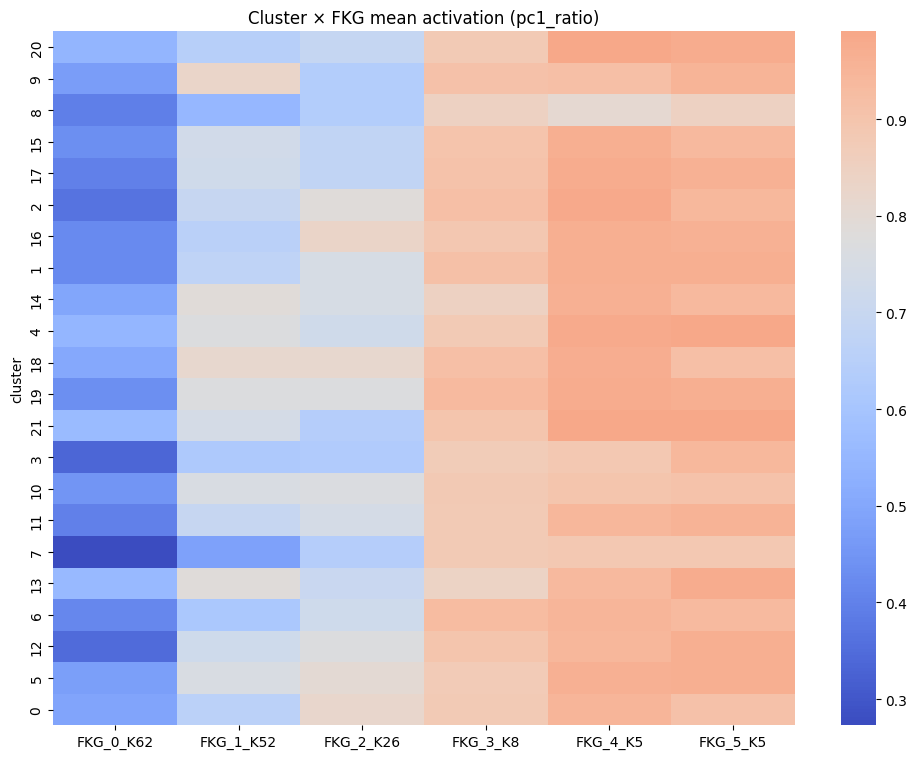

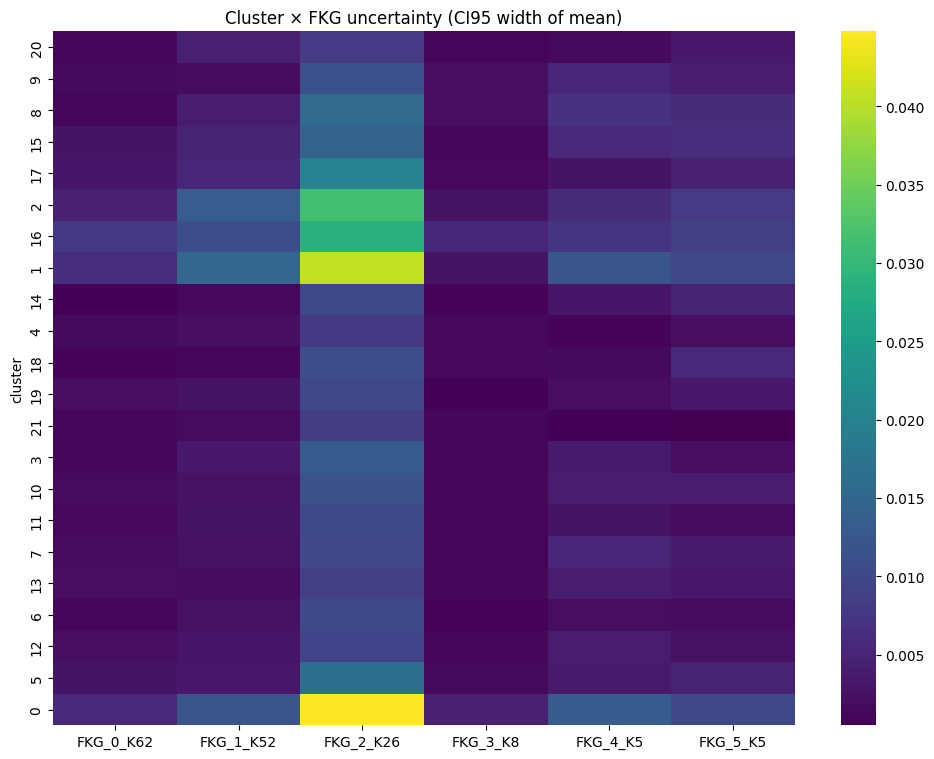

In [20]:

df_mean = pd.read_csv(f"cluster_x_FKG_{METRIC}_mean.csv", index_col=0)
df_ci_lo = pd.read_csv(f"cluster_x_FKG_{METRIC}_ci{CI}_lo.csv", index_col=0)
df_ci_hi = pd.read_csv(f"cluster_x_FKG_{METRIC}_ci{CI}_hi.csv", index_col=0)

fkg_cols = FKG_names

# order if you have group column
if "group" in df_mean.columns:
    df_mean = df_mean.sort_values(["group", "cluster_size"], ascending=[True, False])
    df_ci_lo = df_ci_lo.loc[df_mean.index]
    df_ci_hi = df_ci_hi.loc[df_mean.index]

ci_width = (df_ci_hi[fkg_cols] - df_ci_lo[fkg_cols])

plt.figure(figsize=(10, max(6, 0.35 * df_mean.shape[0])))
sns.heatmap(df_mean[fkg_cols], center=df_mean[fkg_cols].mean().mean(), cmap="coolwarm", yticklabels=True)
plt.title(f"Cluster × FKG mean activation ({METRIC})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, max(6, 0.35 * df_mean.shape[0])))
sns.heatmap(ci_width, cmap="viridis", yticklabels=True)
plt.title(f"Cluster × FKG uncertainty (CI{CI} width of mean)")
plt.tight_layout()
plt.show()


## Shanon Entropy 

In [21]:
# --- INPUTS (must already exist) ---
labels = np.load("HDBSCAN_labels.npy").astype(int)
true_groups = np.load("FKG_activations_true_groups.npy").astype(int)# true_groups   : (N_cycles,)
subject_ids = np.load("FKG_cycle_subject_ids.npy").astype(int)

assert labels.shape == true_groups.shape == subject_ids.shape

# sanity checks
print("Unique groups:", np.unique(true_groups))
print("Subjects:", len(np.unique(subject_ids)))

# each subject must belong to a single group
import pandas as pd
df_check = pd.DataFrame({
    "subject": subject_ids,
    "group": true_groups
})
bad = df_check.groupby("subject")["group"].nunique()
assert (bad <= 1).all(), "ERROR: subject assigned to multiple groups"

Unique groups: [1 2 3]
Subjects: 17


In [ ]:
# Calculate shanon entropy and normalized entropy for each subject

labels = labels.astype(int)
true_groups = true_groups.astype(int)
subject_ids = subject_ids.astype(int)

# Remove noise cycles
mask = labels != -1
labels_v = labels[mask]
groups_v = true_groups[mask]
subjects_v = subject_ids[mask]

def shannon_entropy(counts, base=2):
    p = counts / counts.sum()
    p = p[p > 0]
    return float(-np.sum(p * (np.log(p) / np.log(base))))

def shannon_entropy_normalized(counts):
    K = np.count_nonzero(counts)
    if K <= 1:
        return 0.0
    H = shannon_entropy(counts, base=2)
    return float(H / np.log2(K))

rows = []

for s in np.unique(subjects_v):
    m = subjects_v == s
    labs = labels_v[m]

    # subject group (should be constant)
    grp = int(pd.Series(groups_v[m]).mode().iloc[0])

    uniq, cnt = np.unique(labs, return_counts=True)

    H = shannon_entropy(cnt)
    Hn = shannon_entropy_normalized(cnt)

    rows.append({
        "subject_id": int(s),
        "group": grp,
        "H": H,
        "H_norm": Hn,
        "n_clusters": len(uniq),
        "n_cycles": int(cnt.sum())
    })

dfH = pd.DataFrame(rows)


In [24]:
# make groups 0,1,2 if needed
if dfH["group"].min() == 1 and dfH["group"].max() == 3:
    dfH["group0"] = dfH["group"] - 1
else:
    dfH["group0"] = dfH["group"]

group_labels = {0: "G01 (Young)", 1: "G02 (Middle)", 2: "G03 (Older)"}
dfH["group_name"] = dfH["group0"].map(group_labels)

dfH.to_csv("subject_cluster_shannon_entropy.csv", index=False)
print("Saved: subject_cluster_shannon_entropy.csv")
display(dfH.head())


Saved: subject_cluster_shannon_entropy.csv


,subject_id,group,H,H_norm,n_clusters,n_cycles,group0,group_name
0,2,1,-0.000000,0.00000,1,3158,0,G01 (Young)
1,8,1,1.904097,0.82005,5,2875,0,G01 (Young)
2,13,3,-0.000000,0.00000,1,2769,2,G03 (Older)
3,18,1,-0.000000,0.00000,1,3377,0,G01 (Young)
4,21,1,-0.000000,0.00000,1,3001,0,G01 (Young)


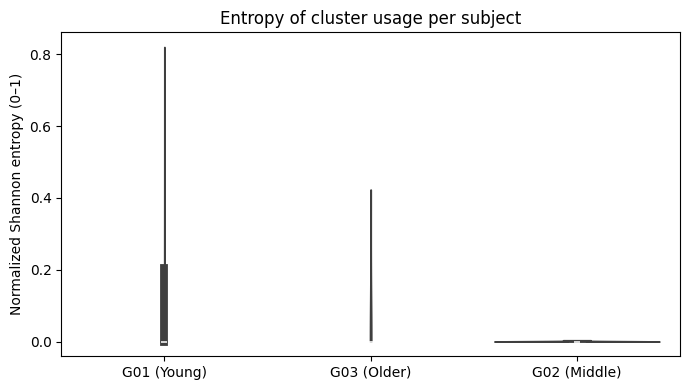

In [25]:
plt.figure(figsize=(7,4))
sns.violinplot(
    data=dfH,
    x="group_name",
    y="H_norm",
    inner="box",
    cut=0
)
plt.ylabel("Normalized Shannon entropy (0–1)")
plt.xlabel("")
plt.title("Entropy of cluster usage per subject")
plt.tight_layout()
plt.show()


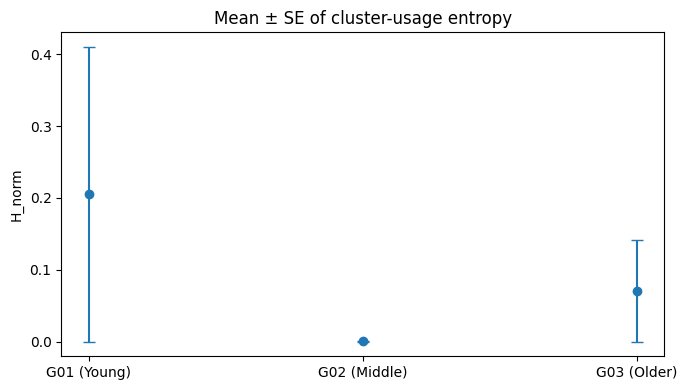

In [26]:
plt.figure(figsize=(7,4))
summary = dfH.groupby("group_name")["H_norm"].agg(["mean", "std", "count"]).reset_index()
summary["se"] = summary["std"] / np.sqrt(summary["count"])

plt.errorbar(summary["group_name"], summary["mean"], yerr=summary["se"], fmt="o", capsize=4)
plt.ylabel("H_norm")
plt.xlabel("")
plt.title("Mean ± SE of cluster-usage entropy")
plt.tight_layout()
plt.show()


In [27]:
from scipy.stats import kruskal, mannwhitneyu

g1 = dfH[dfH["group0"] == 0]["H_norm"].values
g2 = dfH[dfH["group0"] == 1]["H_norm"].values
g3 = dfH[dfH["group0"] == 2]["H_norm"].values

Hstat, p_kw = kruskal(g1, g2, g3)
print("Kruskal–Wallis H =", Hstat, "p =", p_kw)

def mw(a, b):
    return mannwhitneyu(a, b, alternative="two-sided").pvalue

p12 = mw(g1, g2)
p13 = mw(g1, g3)
p23 = mw(g2, g3)

# Bonferroni correction
print("Pairwise MW p (Bonferroni):")
print("G01 vs G02:", min(p12 * 3, 1.0))
print("G01 vs G03:", min(p13 * 3, 1.0))
print("G02 vs G03:", min(p23 * 3, 1.0))


Kruskal–Wallis H = 0.38913072154068945 p = 0.823192372010557
Pairwise MW p (Bonferroni):
G01 vs G02: 1.0
G01 vs G03: 1.0
G02 vs G03: 1.0


In [28]:
# To count subject per group 

df = pd.DataFrame({
    "subject": subject_ids,
    "group": true_groups
})

# un registro por sujeto
df_subj = df.drop_duplicates("subject")

counts = df_subj["group"].value_counts().sort_index()
print("Subjects per group:")
for g, n in counts.items():
    print(f"G0{g}: {n}")

df_subj


Subjects per group:
G01: 4
G02: 7
G03: 6


,subject,group
0,18,1
4056,21,1
7404,2,1
10658,8,1
14980,107,3
18505,119,3
22303,120,3
26116,125,3
29645,13,3
33478,104,3


## Transition Entropy 

In [29]:


df = pd.DataFrame({
    "cycle_id": cycle_ids,
    "subject": subject_ids,
    "group": true_groups
})

# check monotonicity per subject
def check_monotonic(df):
    bad = []
    for subj, d in df.groupby("subject"):
        if not np.all(np.diff(d["cycle_id"].values) >= 0):
            bad.append(subj)
    return bad

bad_subjects = check_monotonic(df)
print("Subjects with non-monotonic cycle_id:", bad_subjects)


Subjects with non-monotonic cycle_id: []


In [36]:
df.shape

(61142, 3)

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 -1 -1 12 12 12 12 12 12 12 12 12 12 12 12 12 12 -1 12 12 -1 12 12
 12 -1]


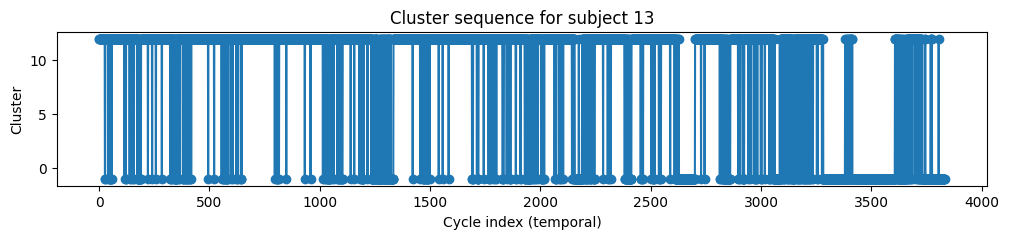

In [39]:
subj = df["subject"].iloc[30000]

seq = labels[subject_ids == subj]

print(seq[:50])

plt.figure(figsize=(12,2))
plt.plot(seq, marker='o')
plt.title(f"Cluster sequence for subject {subj}")
plt.xlabel("Cycle index (temporal)")
plt.ylabel("Cluster")
plt.show()

